In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

In [16]:
file_path = "../s0e_prepData_LnAn/db_LnAn_full.xlsx"
df = pd.read_excel(file_path, header=1)

In [17]:
print("Data point count: ", df.shape[0])
print("Extractant count: ", len(set(df['SMILES'])))

Data point count:  8075
Extractant count:  295


## Draw extractant structure

In [18]:
unique_smiles = df['SMILES'].drop_duplicates().reset_index(drop=True)
unique_smiles_df = pd.DataFrame(unique_smiles)

In [19]:
if False:
    for index, one_smile in unique_smiles_df['SMILES_canonical'].items():
        m = rdkit.Chem.MolFromSmiles(one_smile)
        img = rdkit.Chem.Draw.MolToImage(m, size=(300, 300))
        
        img_file_name = "extractants_chemStructure/chemStructure_SMILES_ID_" + str(index) + ".png"
        img.save(img_file_name)

## Analyze log P

In [20]:
logP_list_all = []
for s in unique_smiles_df['SMILES']:
    mol = rdkit.Chem.MolFromSmiles(s)
    logP_oneMol = rdMolDescriptors.CalcCrippenDescriptors(mol)[0]
    logP_list_all.append(logP_oneMol)
logP_min = min(logP_list_all)
logP_max = max(logP_list_all)
logP_ave = np.average(logP_list_all)
logP_median = np.median(logP_list_all)
print("logP min: ", logP_min)
print("logP max: ", logP_max)
print("logP average: ", logP_ave)
print("logP median: ", logP_median)

logP min:  -2.1634999999999964
logP max:  36.618400000000015
logP average:  7.18957159322034
logP median:  6.293900000000008


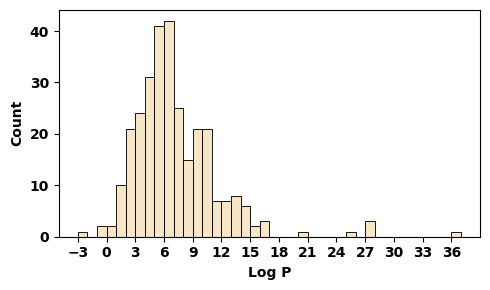

In [21]:
bins = np.arange(-3, 38, 1)

plt.figure(figsize=(5, 3))
sns.histplot(logP_list_all, bins=bins, edgecolor='black', color='wheat')

plt.xlabel('Log P', fontsize=10, fontweight='bold')
plt.ylabel('Count', fontsize=10, fontweight='bold')
plt.xticks(bins[::3], fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Classify extractants

### SMARTS pattern class

Check the link for SMARTS pattern theory: https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html   
Check the link for SMARTS pattern example: https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html

In [22]:
# R-OH, Hydroxyl, hit any structure containing hydroxyl like carboxylic acid
hydroxyl_smarts = "[OX2H]"
# R1-O-R2, Ether, hit only ether
ether_smarts = "[OD2]([#6])[#6]"
# R1-CO-R2, Ketone, hit only ketone
ketone_smarts = "[#6][CX3](=O)[#6]"
# R-COOH, Carboxylic acid, hit only carboxylic acid
carboxylicAcid_smarts = "[CX3](=O)[OX2H1]"

# R-NH2, amine, hit only amine
amine_smarts = "[NX3;H2]"
# R1-CON-R2R3, amide, hit only amide
amide_smarts = "[NX3][CX3](=[OX1])[#6]"
# R1R2-N-CO-C-O-C-CO-N-R3R4, diglycolamide, hit only
diglycolamide_smarts = "[C][NX3]([C])[C](=O)[C][O][C][C](=O)[NX3]([C])[C]"
# diglycolamide_smarts = "[NX3][C](=O)[C][O][C][C](=O)[NX3]" # Use this for any atom in side ring

# PO-, phosphine oxide, hit any like Phosphonic acid
phosphineOxides_smarts = "[PX4](=O)"
# PO-R1R2R3, organophosphine oxide, hit only carbon connections
organoPhosphineOxides_smarts = "[P](=O)(C)(C)C"

# pyridine
pyridine_smarts = "n1ccccc1"

In [23]:
# Classify each molecule
def classify_ligand_smarts(smiles):
    mol = Chem.MolFromSmiles(smiles)
    has_hydroxyl = mol.HasSubstructMatch(Chem.MolFromSmarts(hydroxyl_smarts))
    has_ether = mol.HasSubstructMatch(Chem.MolFromSmarts(ether_smarts))
    has_ketone = mol.HasSubstructMatch(Chem.MolFromSmarts(ketone_smarts))
    has_carboxylicAcid = mol.HasSubstructMatch(Chem.MolFromSmarts(carboxylicAcid_smarts))

    has_amine = mol.HasSubstructMatch(Chem.MolFromSmarts(amine_smarts))
    has_amide = mol.HasSubstructMatch(Chem.MolFromSmarts(amide_smarts))
    has_diglycolamide = mol.HasSubstructMatch(Chem.MolFromSmarts(diglycolamide_smarts))

    has_phosphineOxides = mol.HasSubstructMatch(Chem.MolFromSmarts(phosphineOxides_smarts))
    has_organoPhosphineOxides = mol.HasSubstructMatch(Chem.MolFromSmarts(organoPhosphineOxides_smarts))

    has_pyridine = mol.HasSubstructMatch(Chem.MolFromSmarts(pyridine_smarts))

    classification = []
    if has_hydroxyl:
        classification.append("Hydroxyl")
    if has_ether:
        classification.append("Ether")
    if has_ketone:
        classification.append("Ketone")
    if has_carboxylicAcid:
        classification.append("Carboxylic Acid")

    if has_amine:
        classification.append("Amine")
    if has_amide:
        classification.append("Amide")
    if has_diglycolamide:
        classification.append("Diglycolamide")

    if has_phosphineOxides:
        classification.append("Phosphine Oxides")
    if has_organoPhosphineOxides:
        classification.append("Organophosphine Oxides")

    if has_pyridine:
        classification.append("Pyridine")
    
    if not classification:
        classification.append("Other")

    classification_str = ', '.join(classification)

    return classification_str

In [24]:
unique_smiles_smart_df = pd.DataFrame(unique_smiles)

unique_smiles_smart_df['Class_by_SMARTS'] = unique_smiles_smart_df['SMILES'].apply(classify_ligand_smarts)
unique_smiles_smart_df

,SMILES,Class_by_SMARTS
0,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@H](C)C(=O)...,"Ether, Amide, Diglycolamide"
1,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@@H](C)C(=O...,"Ether, Amide, Diglycolamide"
2,CN(C(=O)COCC(=O)N(C)c1ccccc1)c1ccccc1,"Ether, Amide"
3,CCCCN(CCCC)C(=O)COCC(=O)N(CC)CCN(CC)C(=O)COCC(...,"Ether, Amide, Diglycolamide"
4,CCCCN(CCCC)C(=O)COCC(=O)N(CCN(C(=O)COCC(=O)N(C...,"Ether, Amide, Diglycolamide"
...,...,...
290,CCCCCCCCNC(=O)CC(=O)NCc1ccc(CNC(=O)CC(=O)NCCCC...,Amide
291,CCCCNC(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC)C(=O)N...,Amide
292,CCCCCCCCNC(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC)C(...,Amide
293,CCCCCCCCN(C)C(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC...,Amide


In [25]:
unique_smiles_smart_df.groupby(by=['Class_by_SMARTS']).count()

,SMILES
Class_by_SMARTS,
Amide,65
"Amide, Phosphine Oxides",9
"Amide, Phosphine Oxides, Organophosphine Oxides",7
"Amide, Pyridine",32
Ether,7
"Ether, Amide",40
"Ether, Amide, Diglycolamide",62
"Ether, Amide, Phosphine Oxides",2
"Ether, Amide, Phosphine Oxides, Organophosphine Oxides",1


### SMILES map DOI

In [27]:
df_unique_smiles_doi = df.drop_duplicates(subset=['SMILES', 'DOI'])
doi_mapping_df = df_unique_smiles_doi.groupby('SMILES')['DOI'].apply(lambda x: ';'.join(x)).reset_index()
unique_smiles_smart_df = pd.merge(unique_smiles_smart_df, doi_mapping_df, on='SMILES', how='left')
unique_smiles_smart_df = unique_smiles_smart_df.rename(columns={'DOI': 'SMILES_DOI'})
# unique_smiles_smart_df = unique_smiles_smart_df.rename(columns={'SMILES_canonical': 'SMILES'})
unique_smiles_smart_df

,SMILES,Class_by_SMARTS,SMILES_DOI
0,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@H](C)C(=O)...,"Ether, Amide, Diglycolamide",https://doi.org/10.1002/chem.201806161
1,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@@H](C)C(=O...,"Ether, Amide, Diglycolamide",https://doi.org/10.1002/chem.201806161
2,CN(C(=O)COCC(=O)N(C)c1ccccc1)c1ccccc1,"Ether, Amide",https://doi.org/10.1007/BF02349516;https://doi...
3,CCCCN(CCCC)C(=O)COCC(=O)N(CC)CCN(CC)C(=O)COCC(...,"Ether, Amide, Diglycolamide",https://doi.org/10.1007/s10967-017-5248-4
4,CCCCN(CCCC)C(=O)COCC(=O)N(CCN(C(=O)COCC(=O)N(C...,"Ether, Amide, Diglycolamide",https://doi.org/10.1007/s10967-017-5248-4
...,...,...,...
290,CCCCCCCCNC(=O)CC(=O)NCc1ccc(CNC(=O)CC(=O)NCCCC...,Amide,https://doi.org/10.1524/ract.2008.1485
291,CCCCNC(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC)C(=O)N...,Amide,https://doi.org/10.1524/ract.2008.1485
292,CCCCCCCCNC(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC)C(...,Amide,https://doi.org/10.1524/ract.2008.1485
293,CCCCCCCCN(C)C(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC...,Amide,https://doi.org/10.1524/ract.2008.1485


In [28]:
unique_smiles_smart_df.to_excel('output_uniqueSMILES_ClassBySMARTS.xlsx', index=True, index_label='SMILES_ID')

In [29]:
smiles_class_mapping_df = pd.DataFrame(columns=['SMILES', 'One_class_by_SMARTS'])
for index, row in unique_smiles_smart_df.iterrows():
    for one_class in row['Class_by_SMARTS'].split(','):
        one_class = one_class.strip()
        one_class_df = pd.DataFrame([[row['SMILES'], one_class]], columns=['SMILES', 'One_class_by_SMARTS'])
        smiles_class_mapping_df = pd.concat([smiles_class_mapping_df, one_class_df])
smiles_class_mapping_df = smiles_class_mapping_df.reset_index(drop=True)
smiles_class_mapping_df

,SMILES,One_class_by_SMARTS
0,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@H](C)C(=O)...,Ether
1,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@H](C)C(=O)...,Amide
2,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@H](C)C(=O)...,Diglycolamide
3,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@@H](C)C(=O...,Ether
4,CCCCCCCCN(CCCCCCCC)C(=O)[C@H](C)O[C@@H](C)C(=O...,Amide
...,...,...
550,CCCCCCCCNC(=O)CC(=O)NCc1ccc(CNC(=O)CC(=O)NCCCC...,Amide
551,CCCCNC(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC)C(=O)N...,Amide
552,CCCCCCCCNC(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC)C(...,Amide
553,CCCCCCCCN(C)C(=O)C(CC)C(=O)NCc1ccc(CNC(=O)C(CC...,Amide


In [30]:
smiles_class_mapping_df.groupby(by=['One_class_by_SMARTS']).count()

,SMILES
One_class_by_SMARTS,
Amide,223
Carboxylic Acid,4
Diglycolamide,62
Ether,120
Hydroxyl,8
Ketone,4
Organophosphine Oxides,11
Other,13
Phosphine Oxides,37


### Visualize SMARTS pattern

In [ ]:
from IPython.display import Image
from IPython.display import display
import requests

In [ ]:
baseurl = "https://smarts.plus/smartsview/download_rest?"
def get_smarts_structure(query):
    url = baseurl+query
    res = requests.get(url)
    return Image(res.content)
    # return res.content

Check the link: https://smarts.plus/rest

In [ ]:
def get_query(smarts):
    # The Following characters have to be escaped
    smarts = smarts.replace("%", "%25")
    smarts = smarts.replace("&", "%26")
    smarts = smarts.replace("+", "%2B")
    smarts = smarts.replace("#", "%23")
    smarts = smarts.replace(";", "%3B")

    query = 'smarts=' + smarts
    return query

In [ ]:
name_smarts_dic = {
    "hydroxyl": hydroxyl_smarts,
    "ether": ether_smarts,
    "ketone": ketone_smarts,
    "carboxylicAcid": carboxylicAcid_smarts,

    "amine": amine_smarts,
    "amide": amide_smarts,
    "diglycolamide": diglycolamide_smarts,

    "phosphineOxides": phosphineOxides_smarts,
    "organophosphineOxides": organoPhosphineOxides_smarts,

    "pyridine":pyridine_smarts
}
name_smarts_series = pd.Series(name_smarts_dic)
name_smarts_series

hydroxyl                                                            [OX2H]
ether                                                      [OD2]([#6])[#6]
ketone                                                   [#6][CX3](=O)[#6]
carboxylicAcid                                            [CX3](=O)[OX2H1]
amine                                                             [NX3;H2]
amide                                               [NX3][CX3](=[OX1])[#6]
diglycolamide            [C][NX3]([C])[C](=O)[C][O][C][C](=O)[NX3]([C])[C]
phosphineOxides                                                  [PX4](=O)
organophosphineOxides                                       [P](=O)(C)(C)C
pyridine                                                          n1ccccc1
dtype: object

hydroxyl


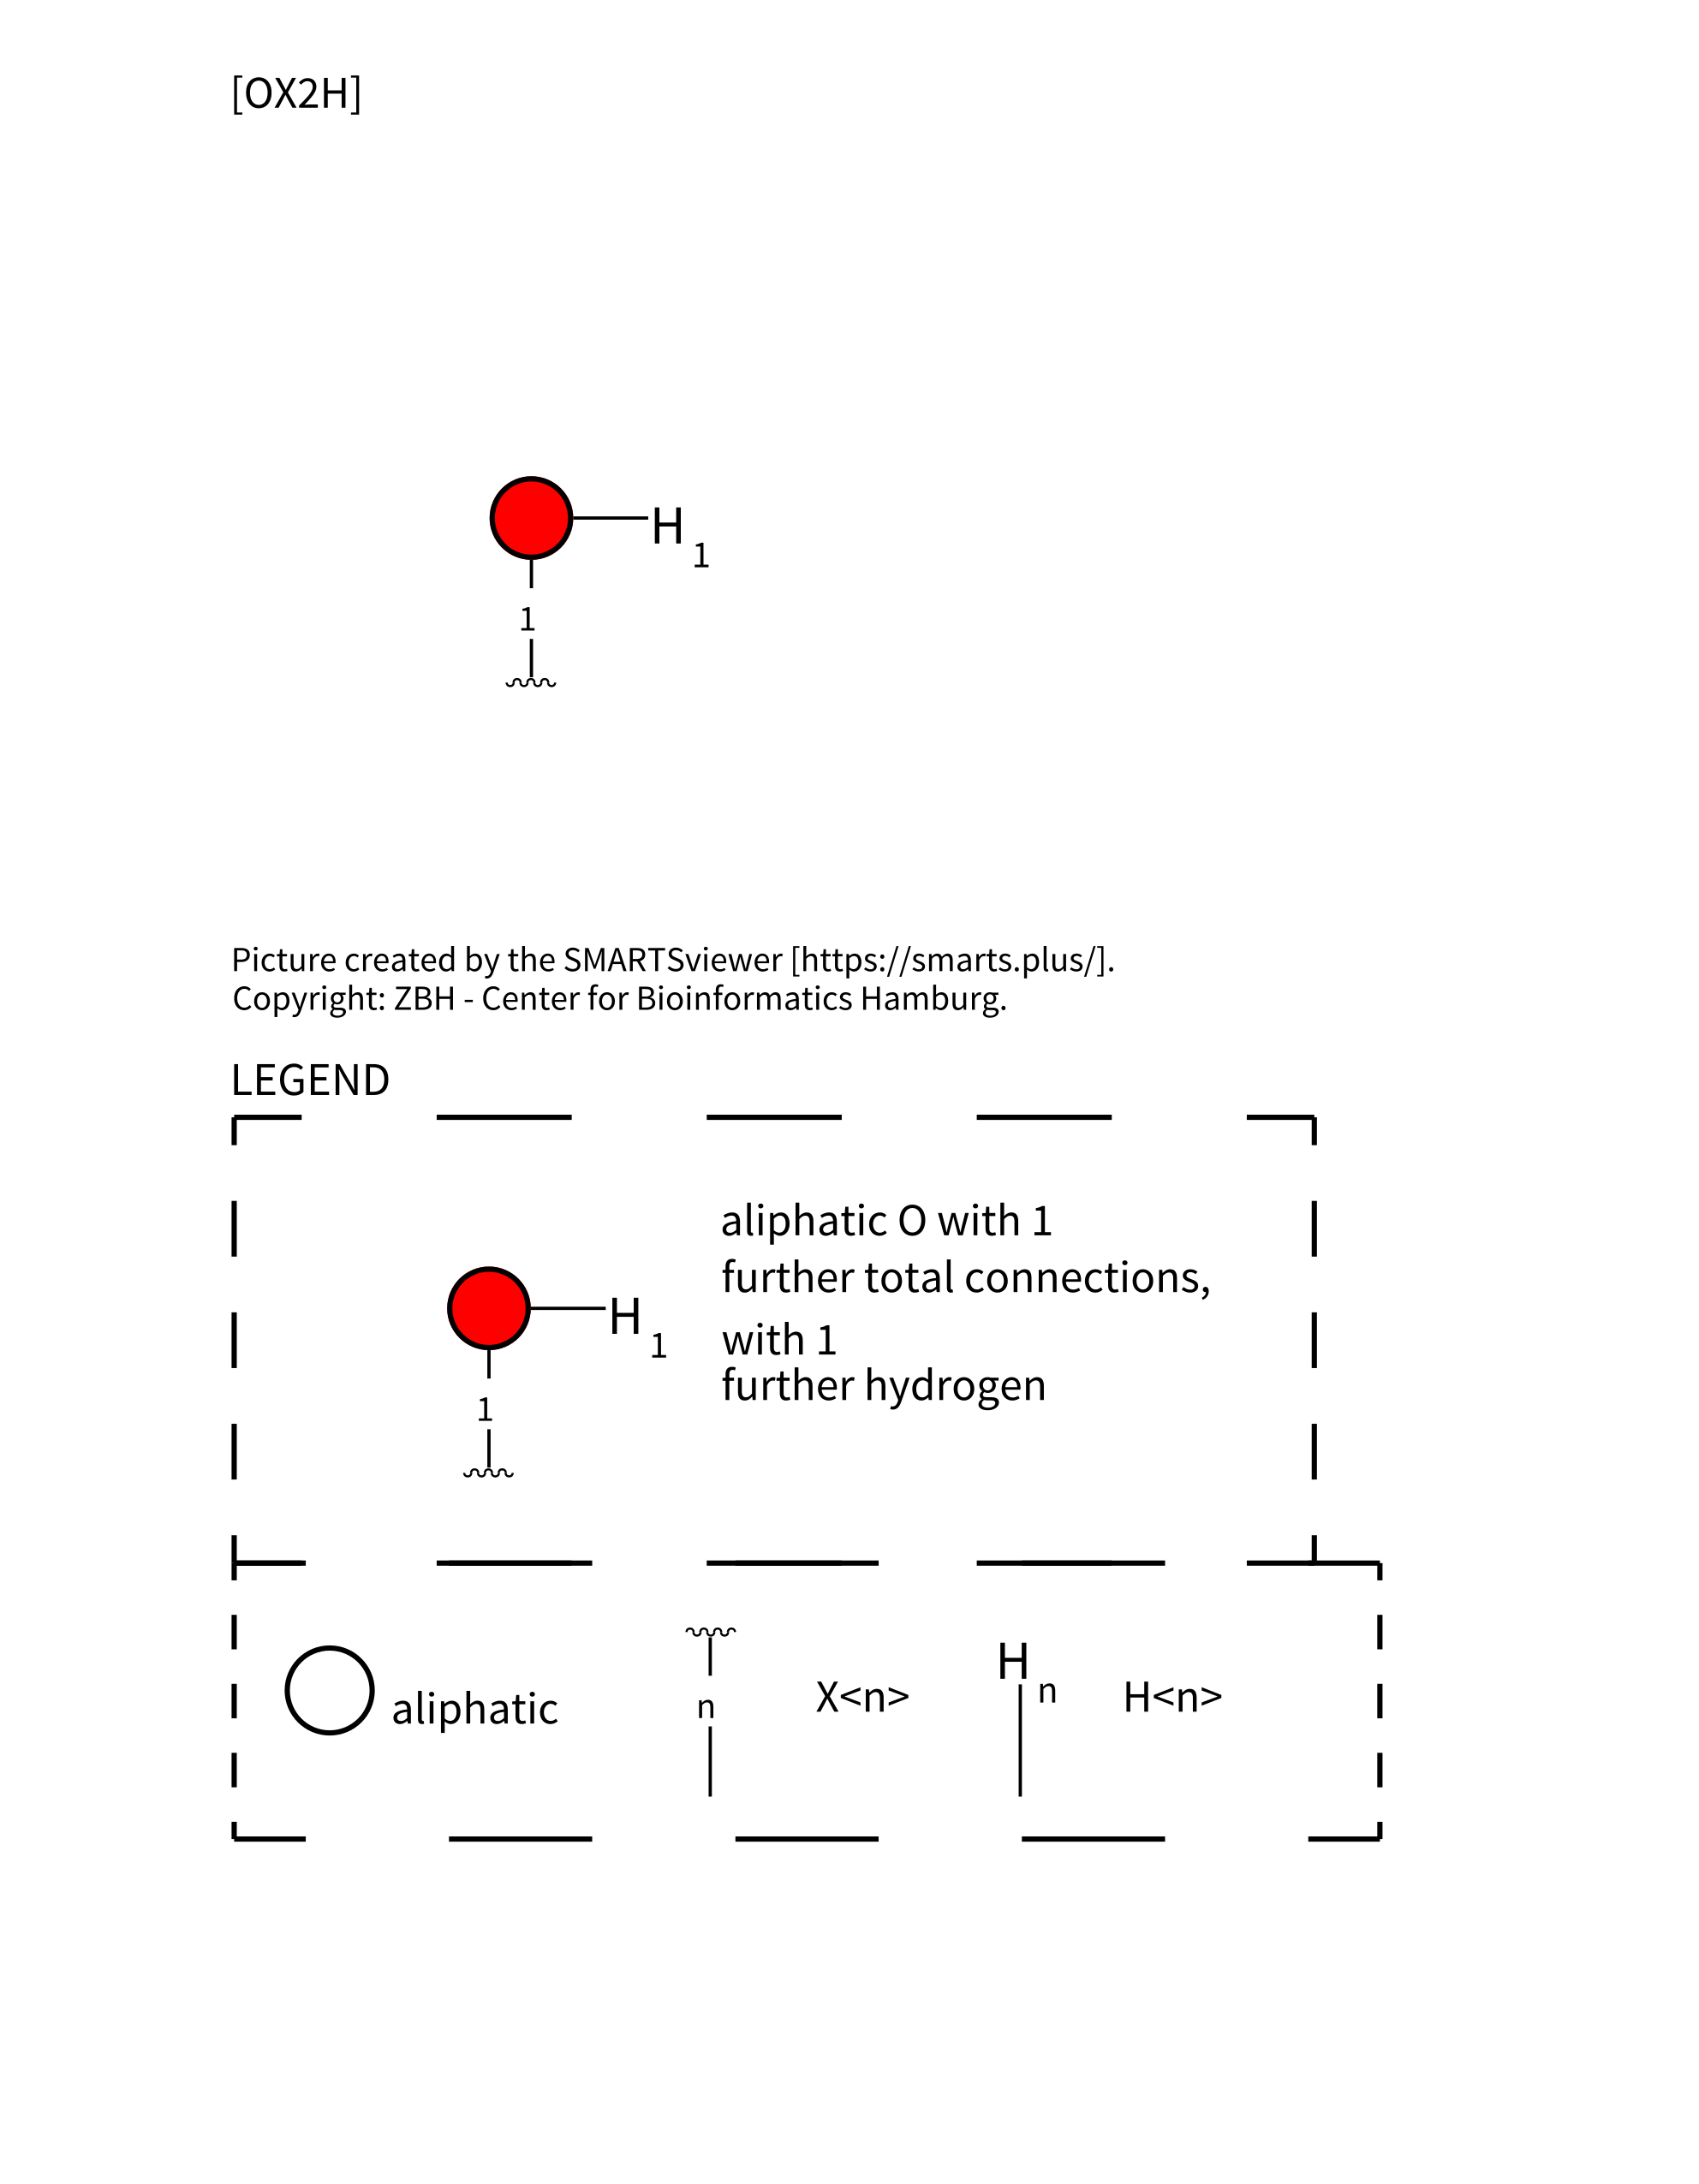

ether


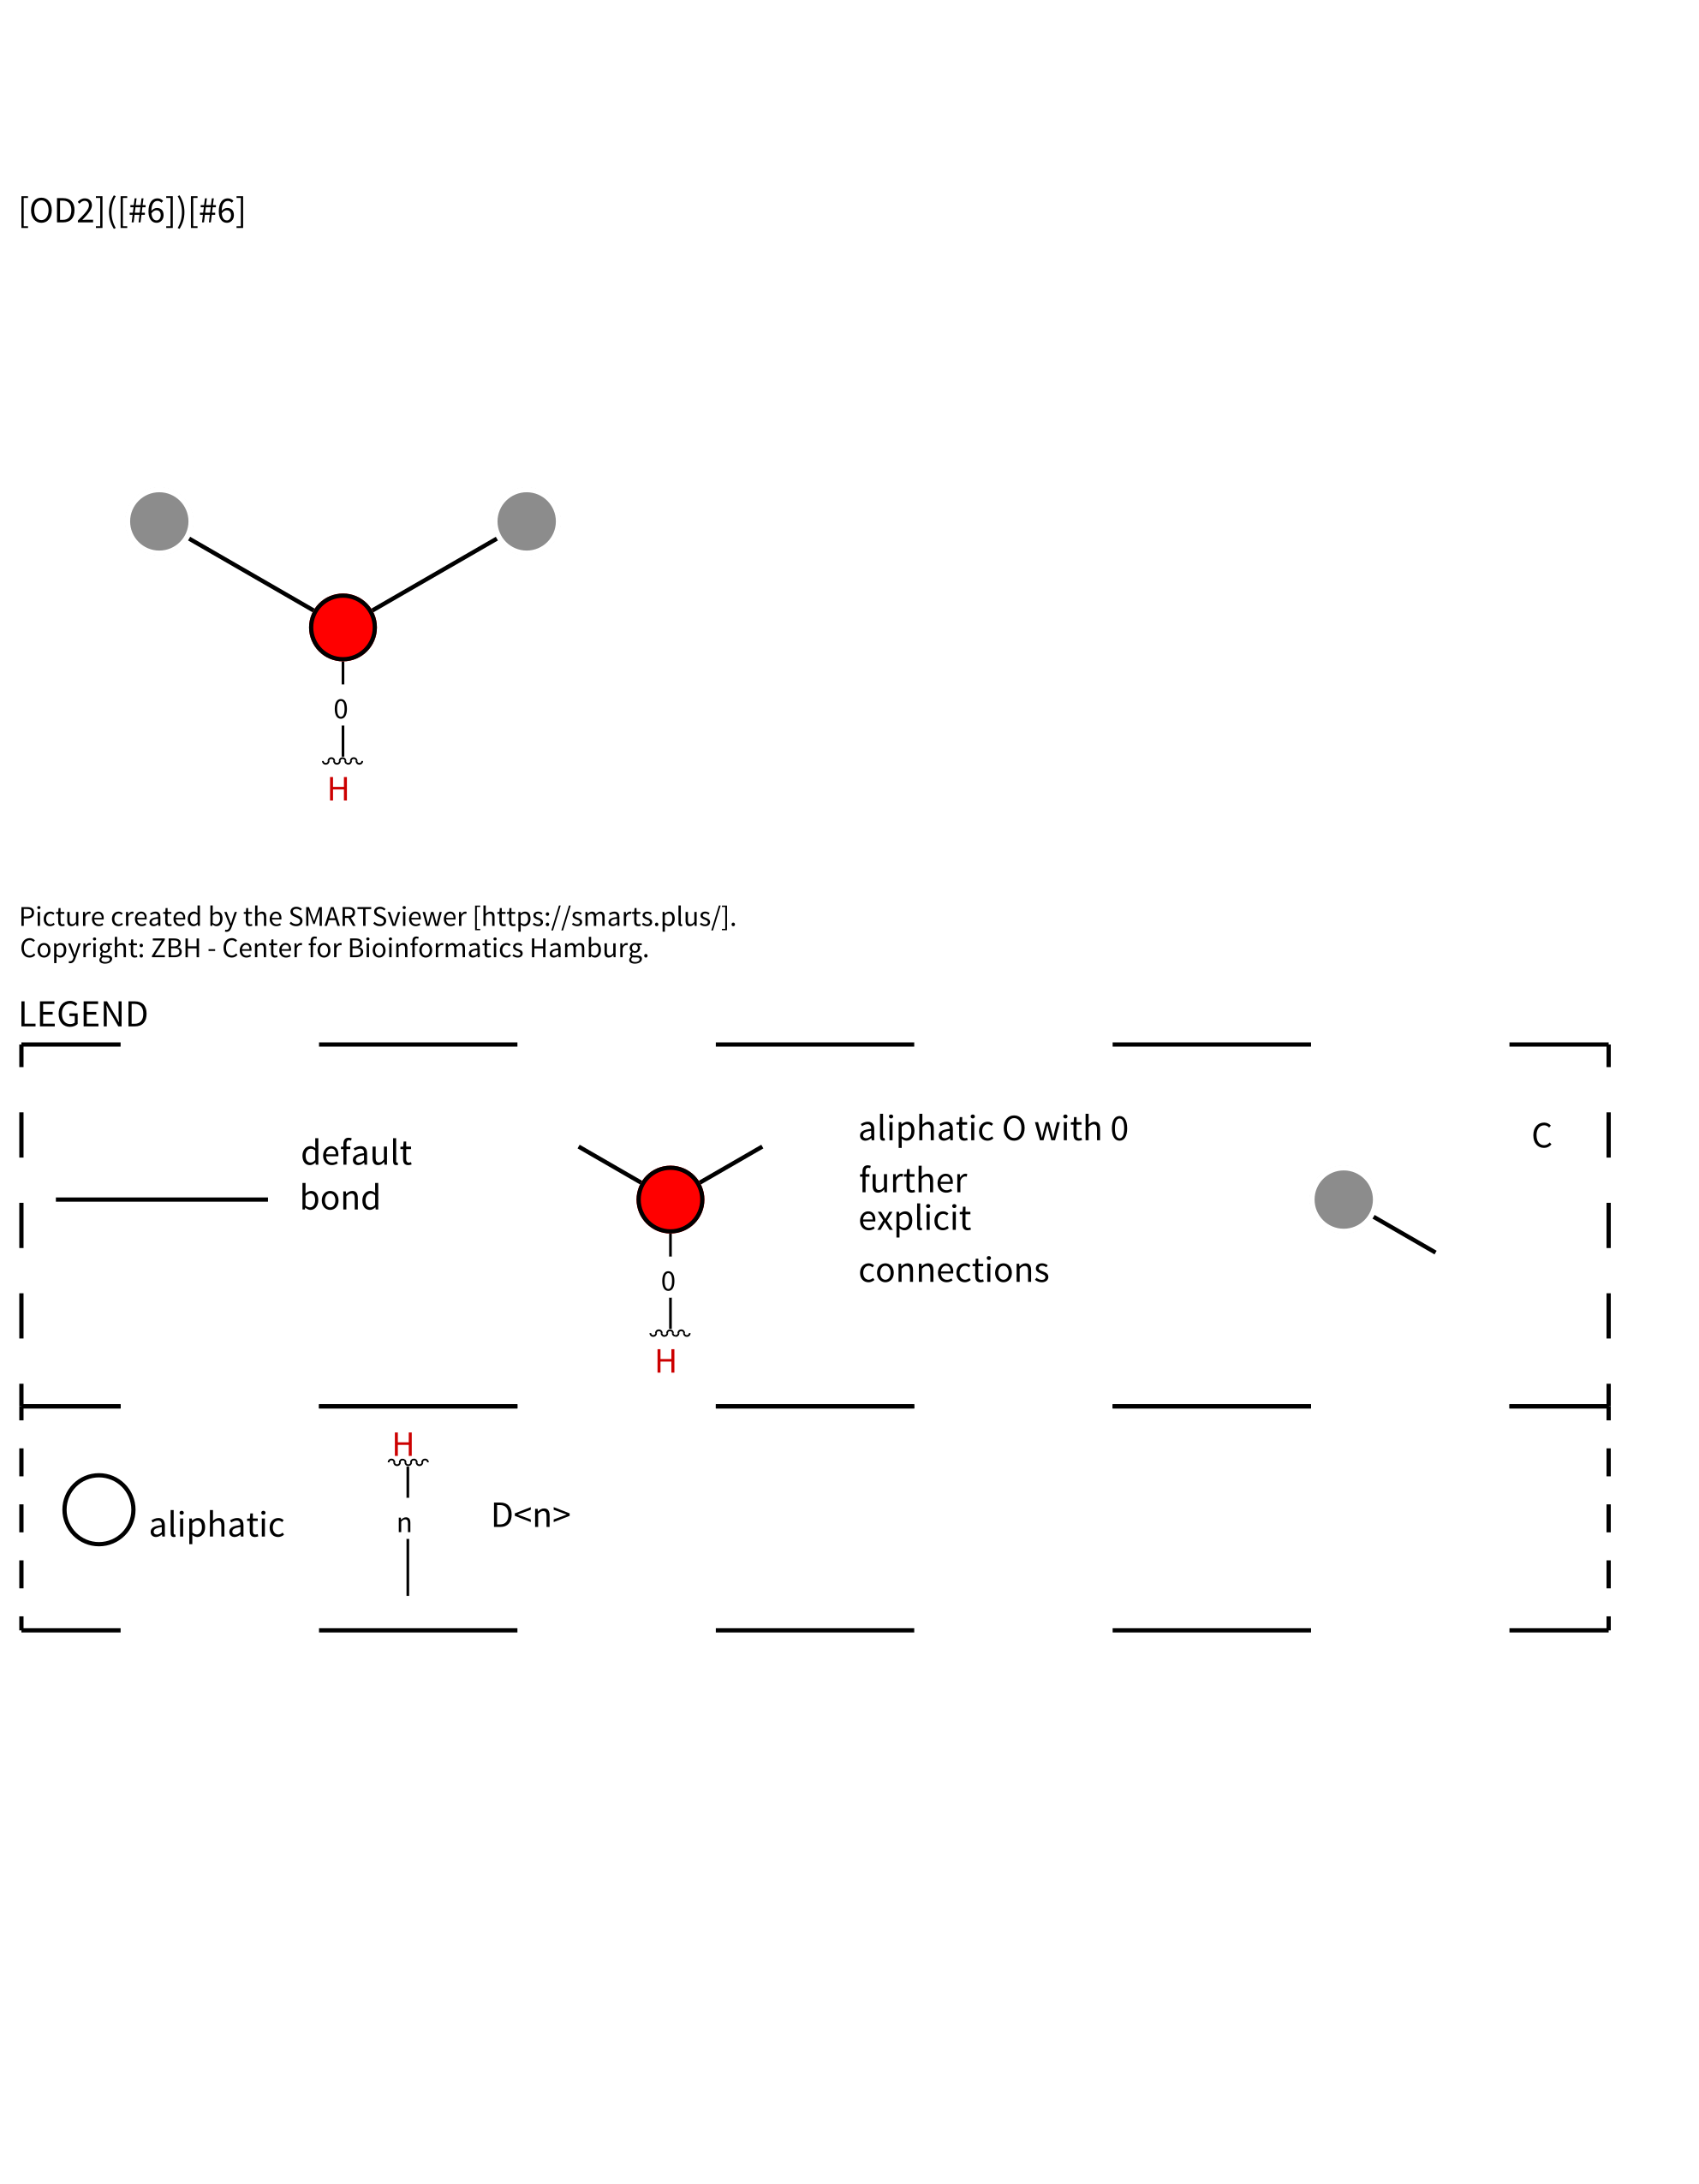

ketone


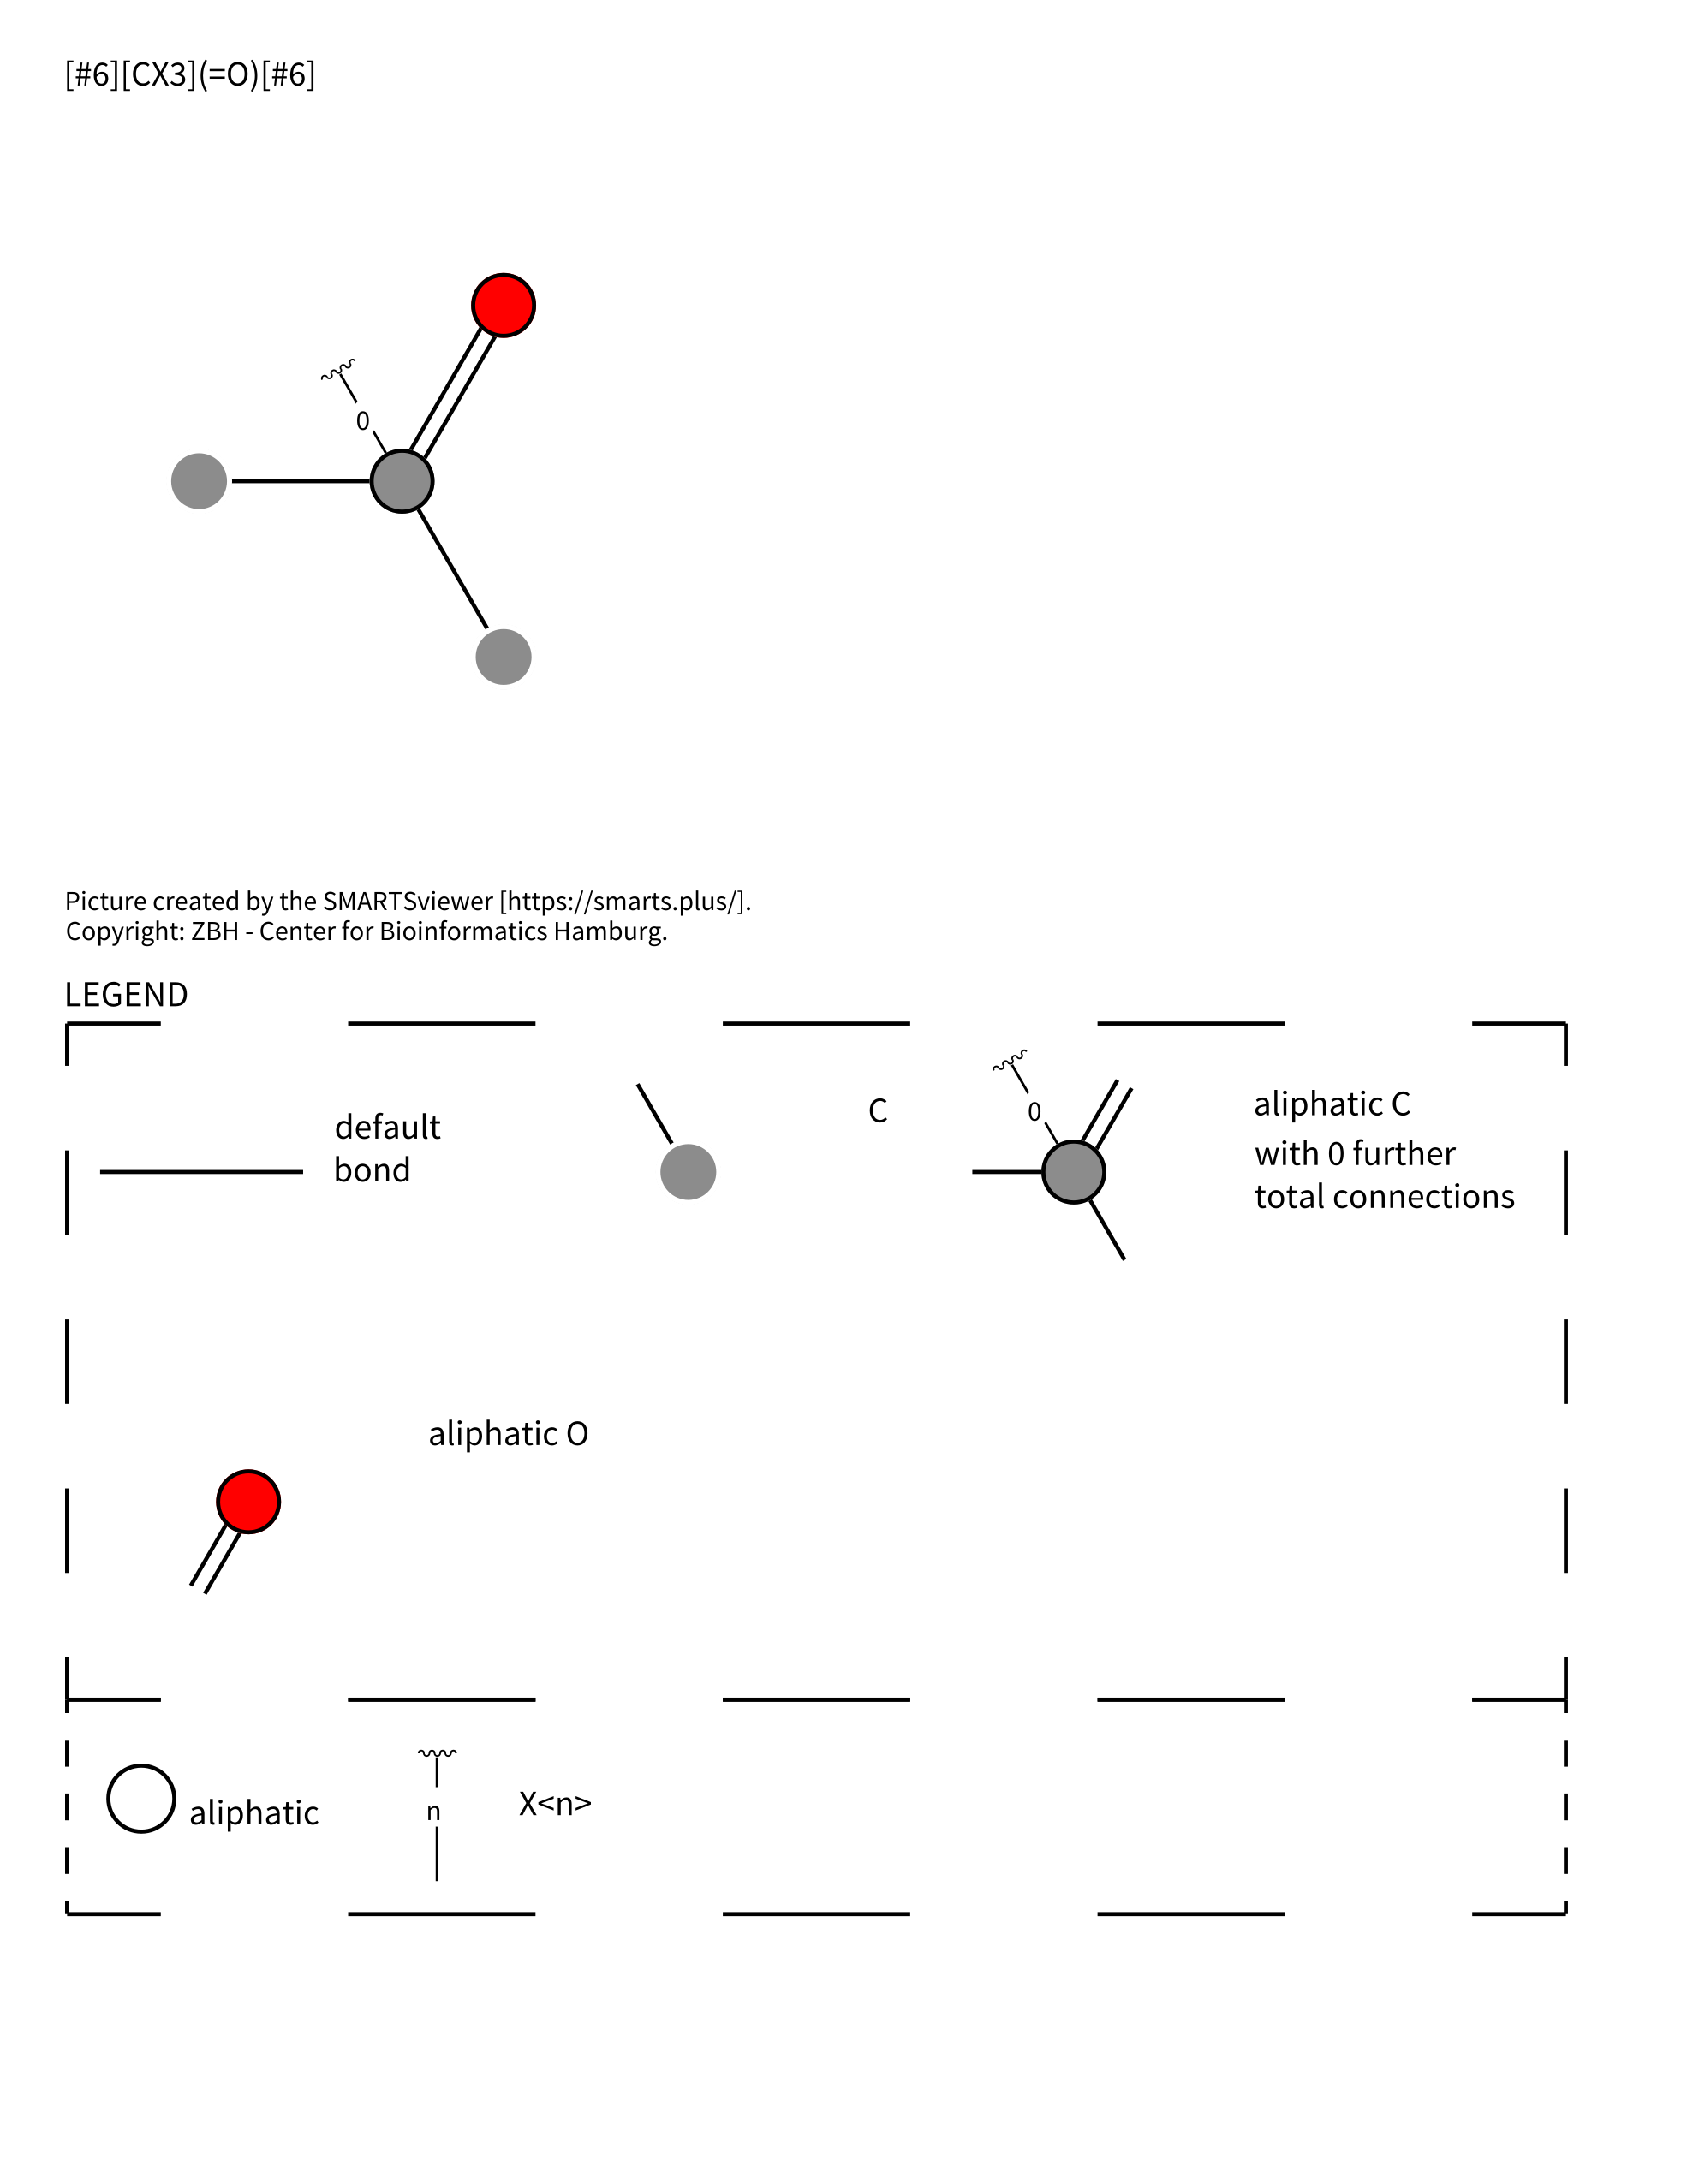

carboxylicAcid


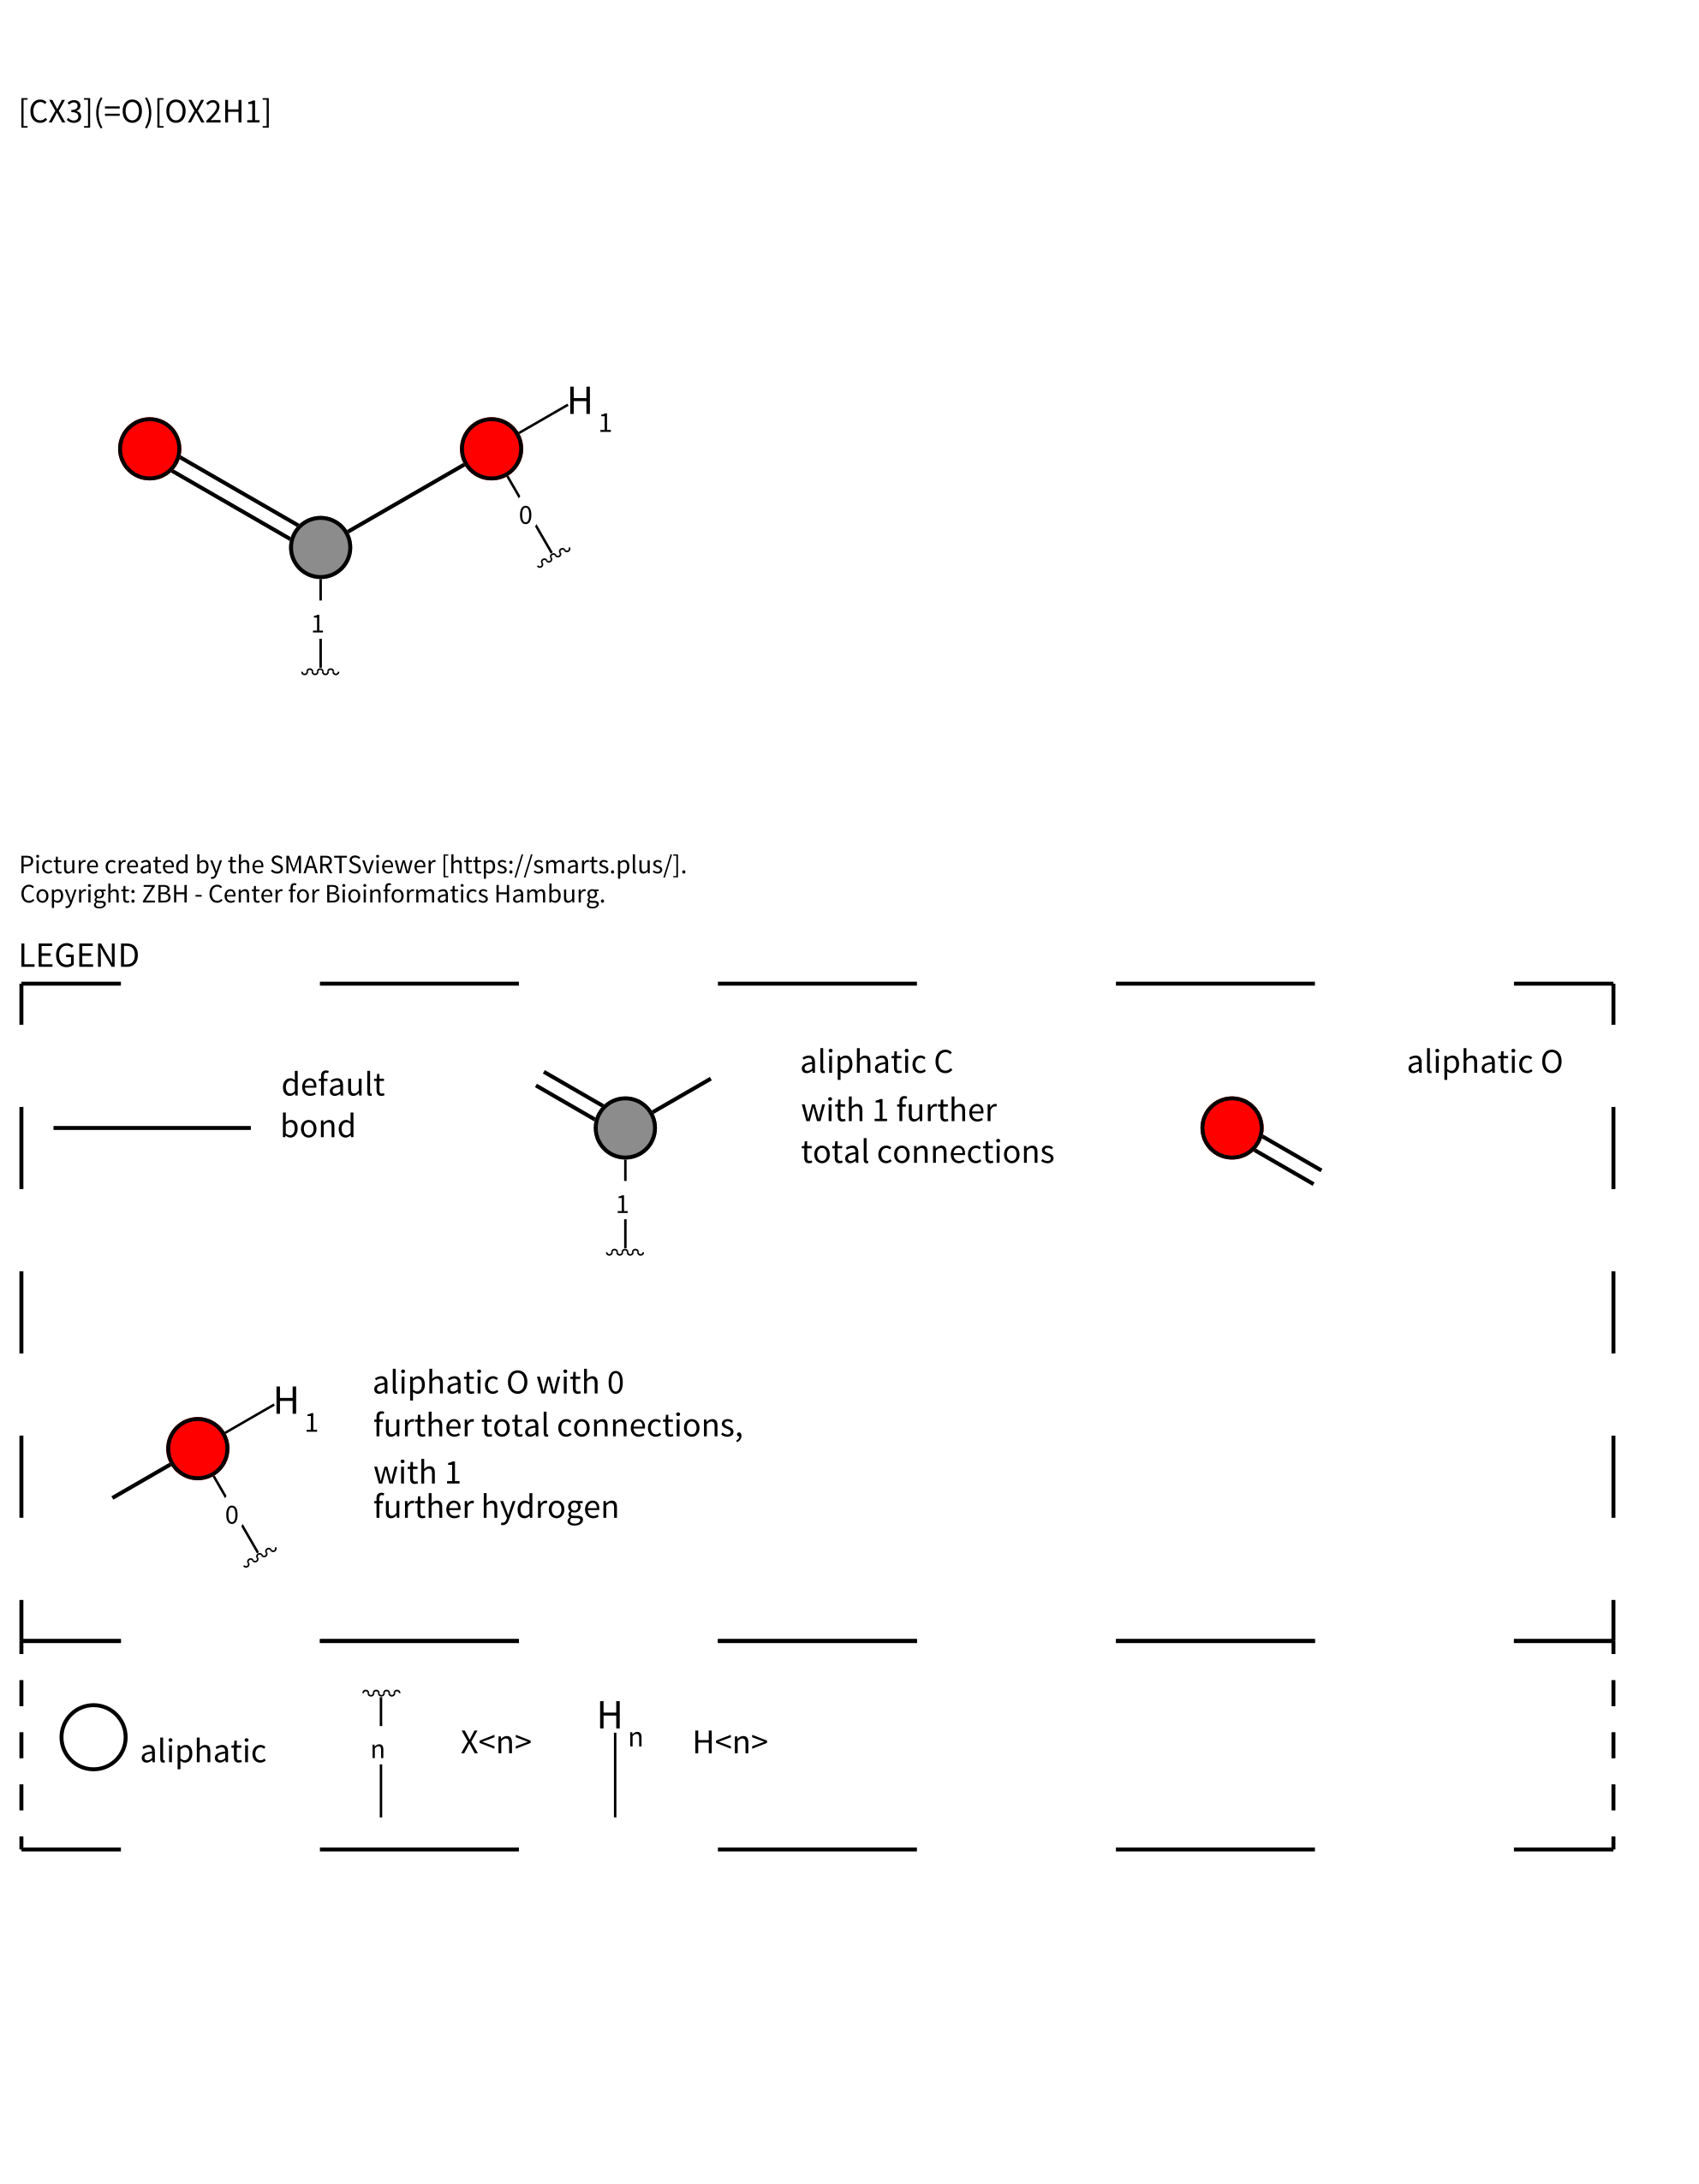

amine


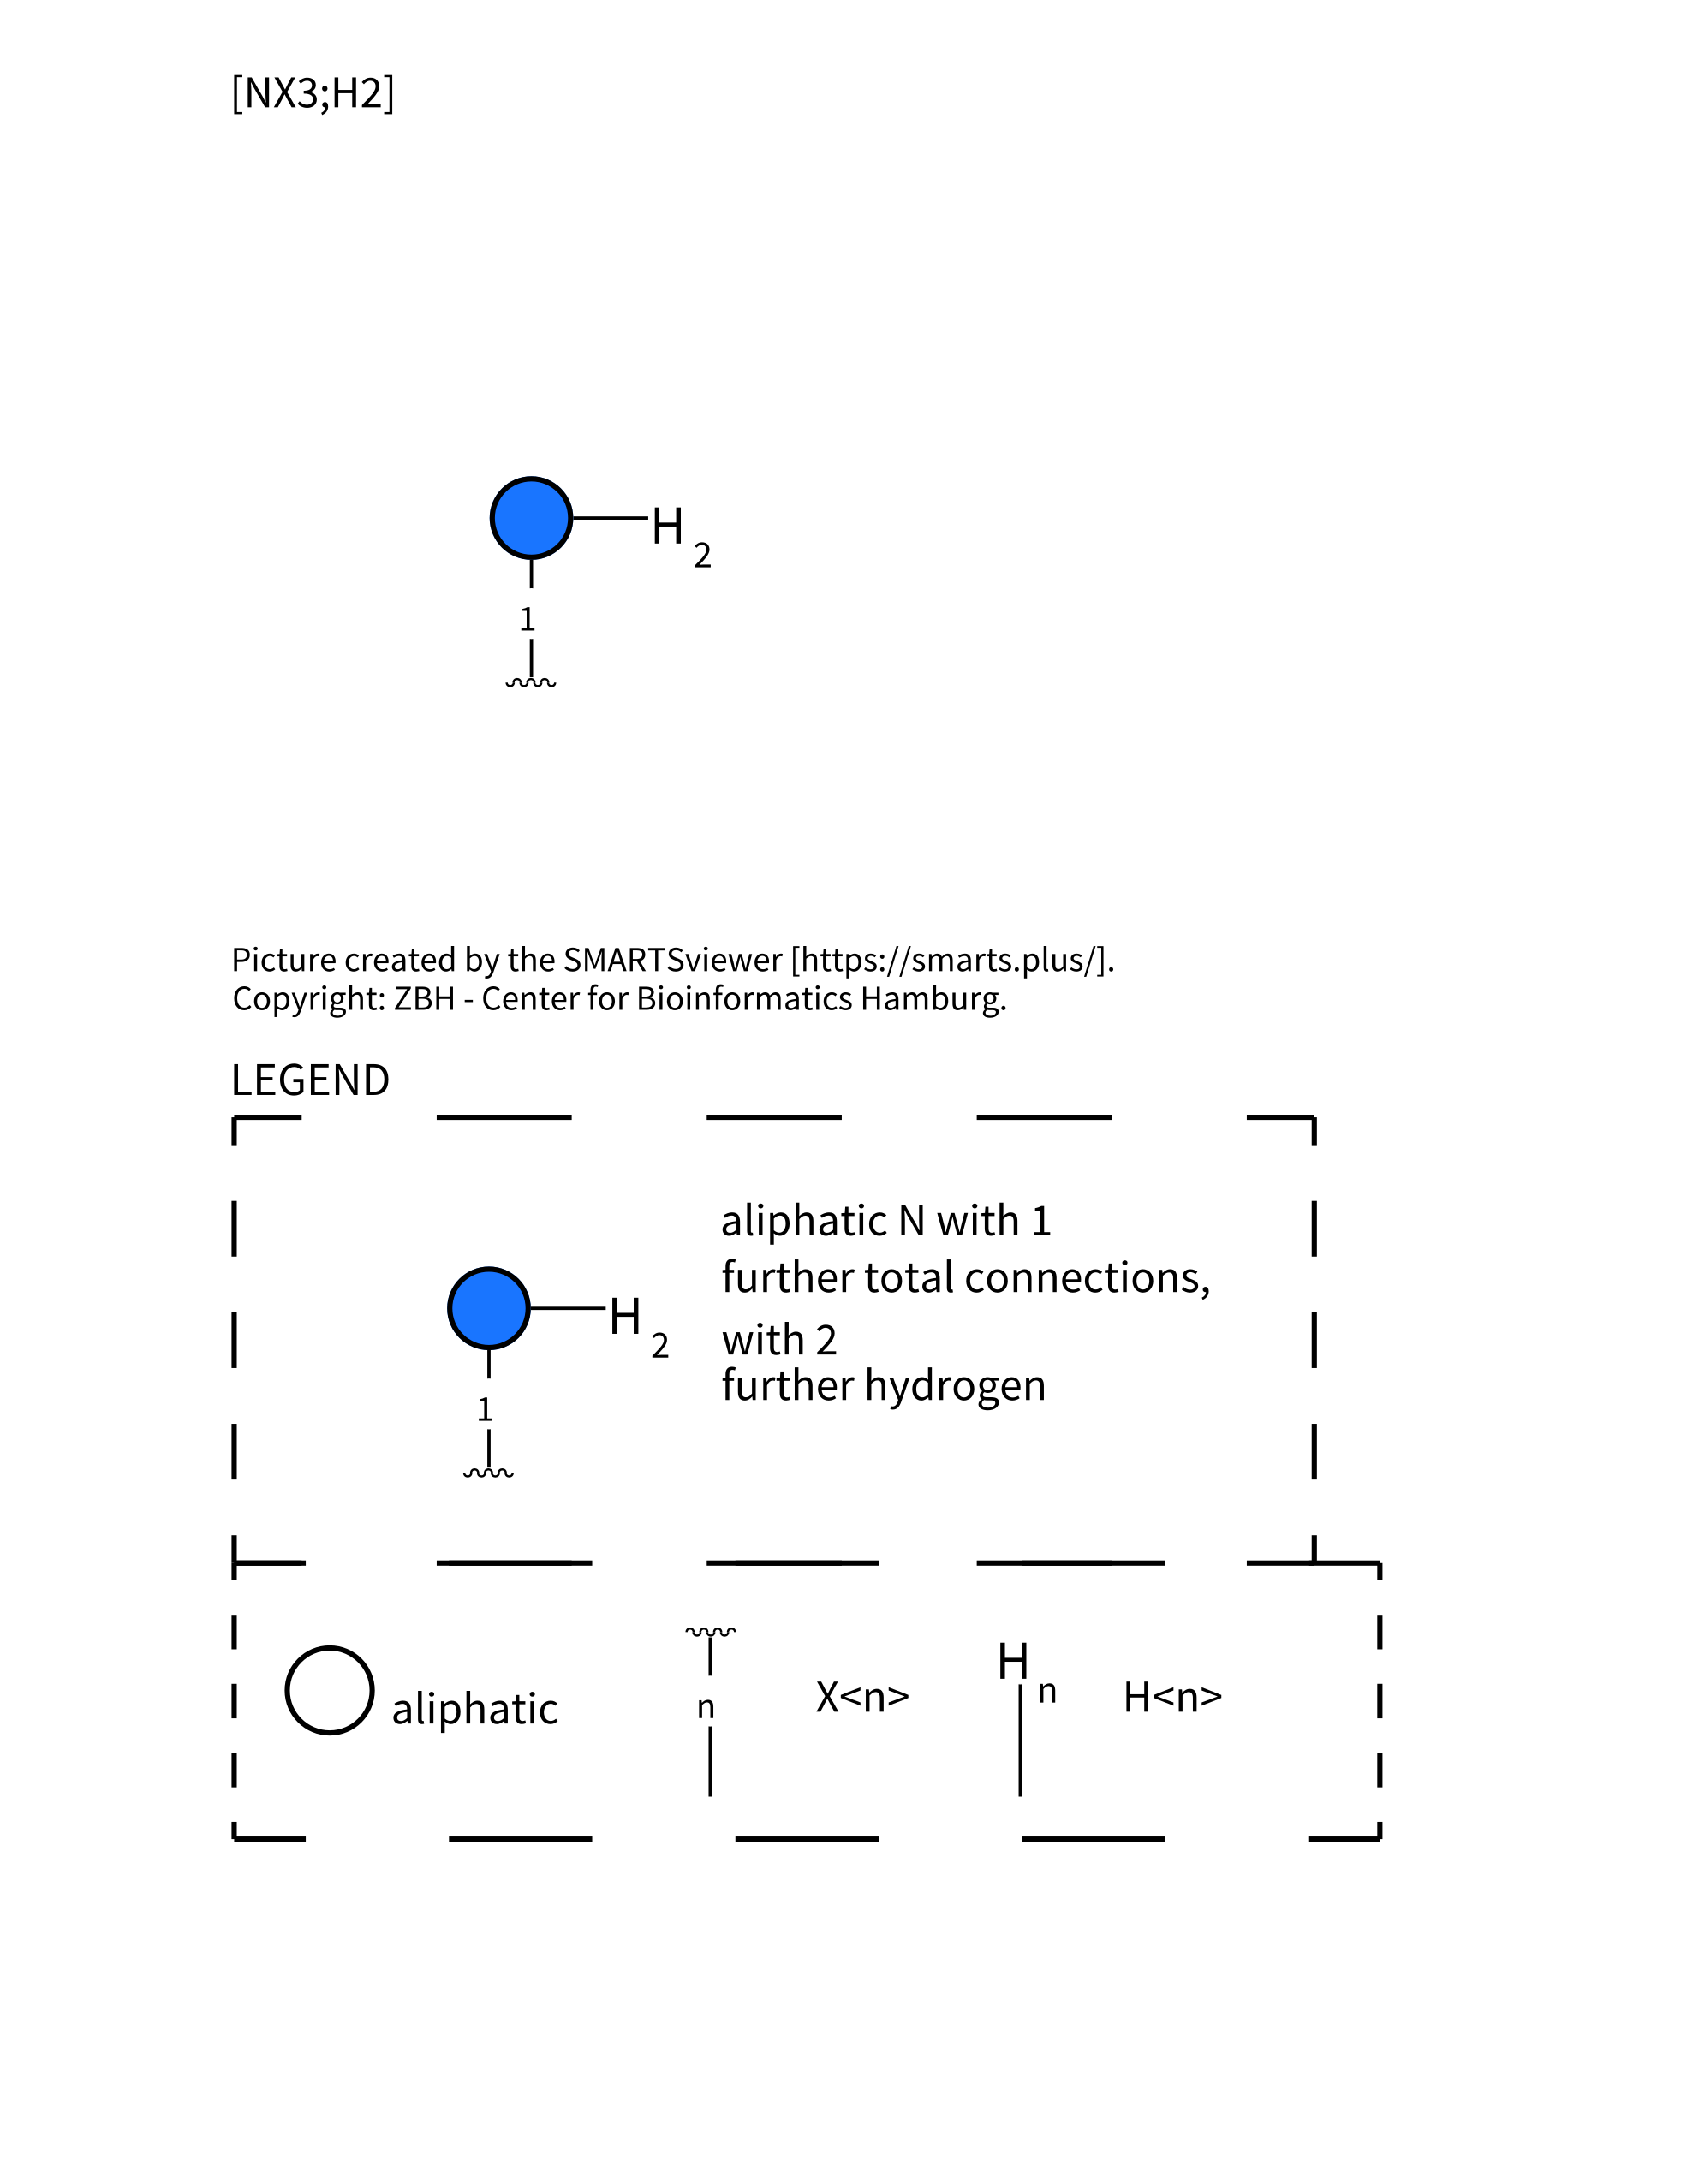

amide


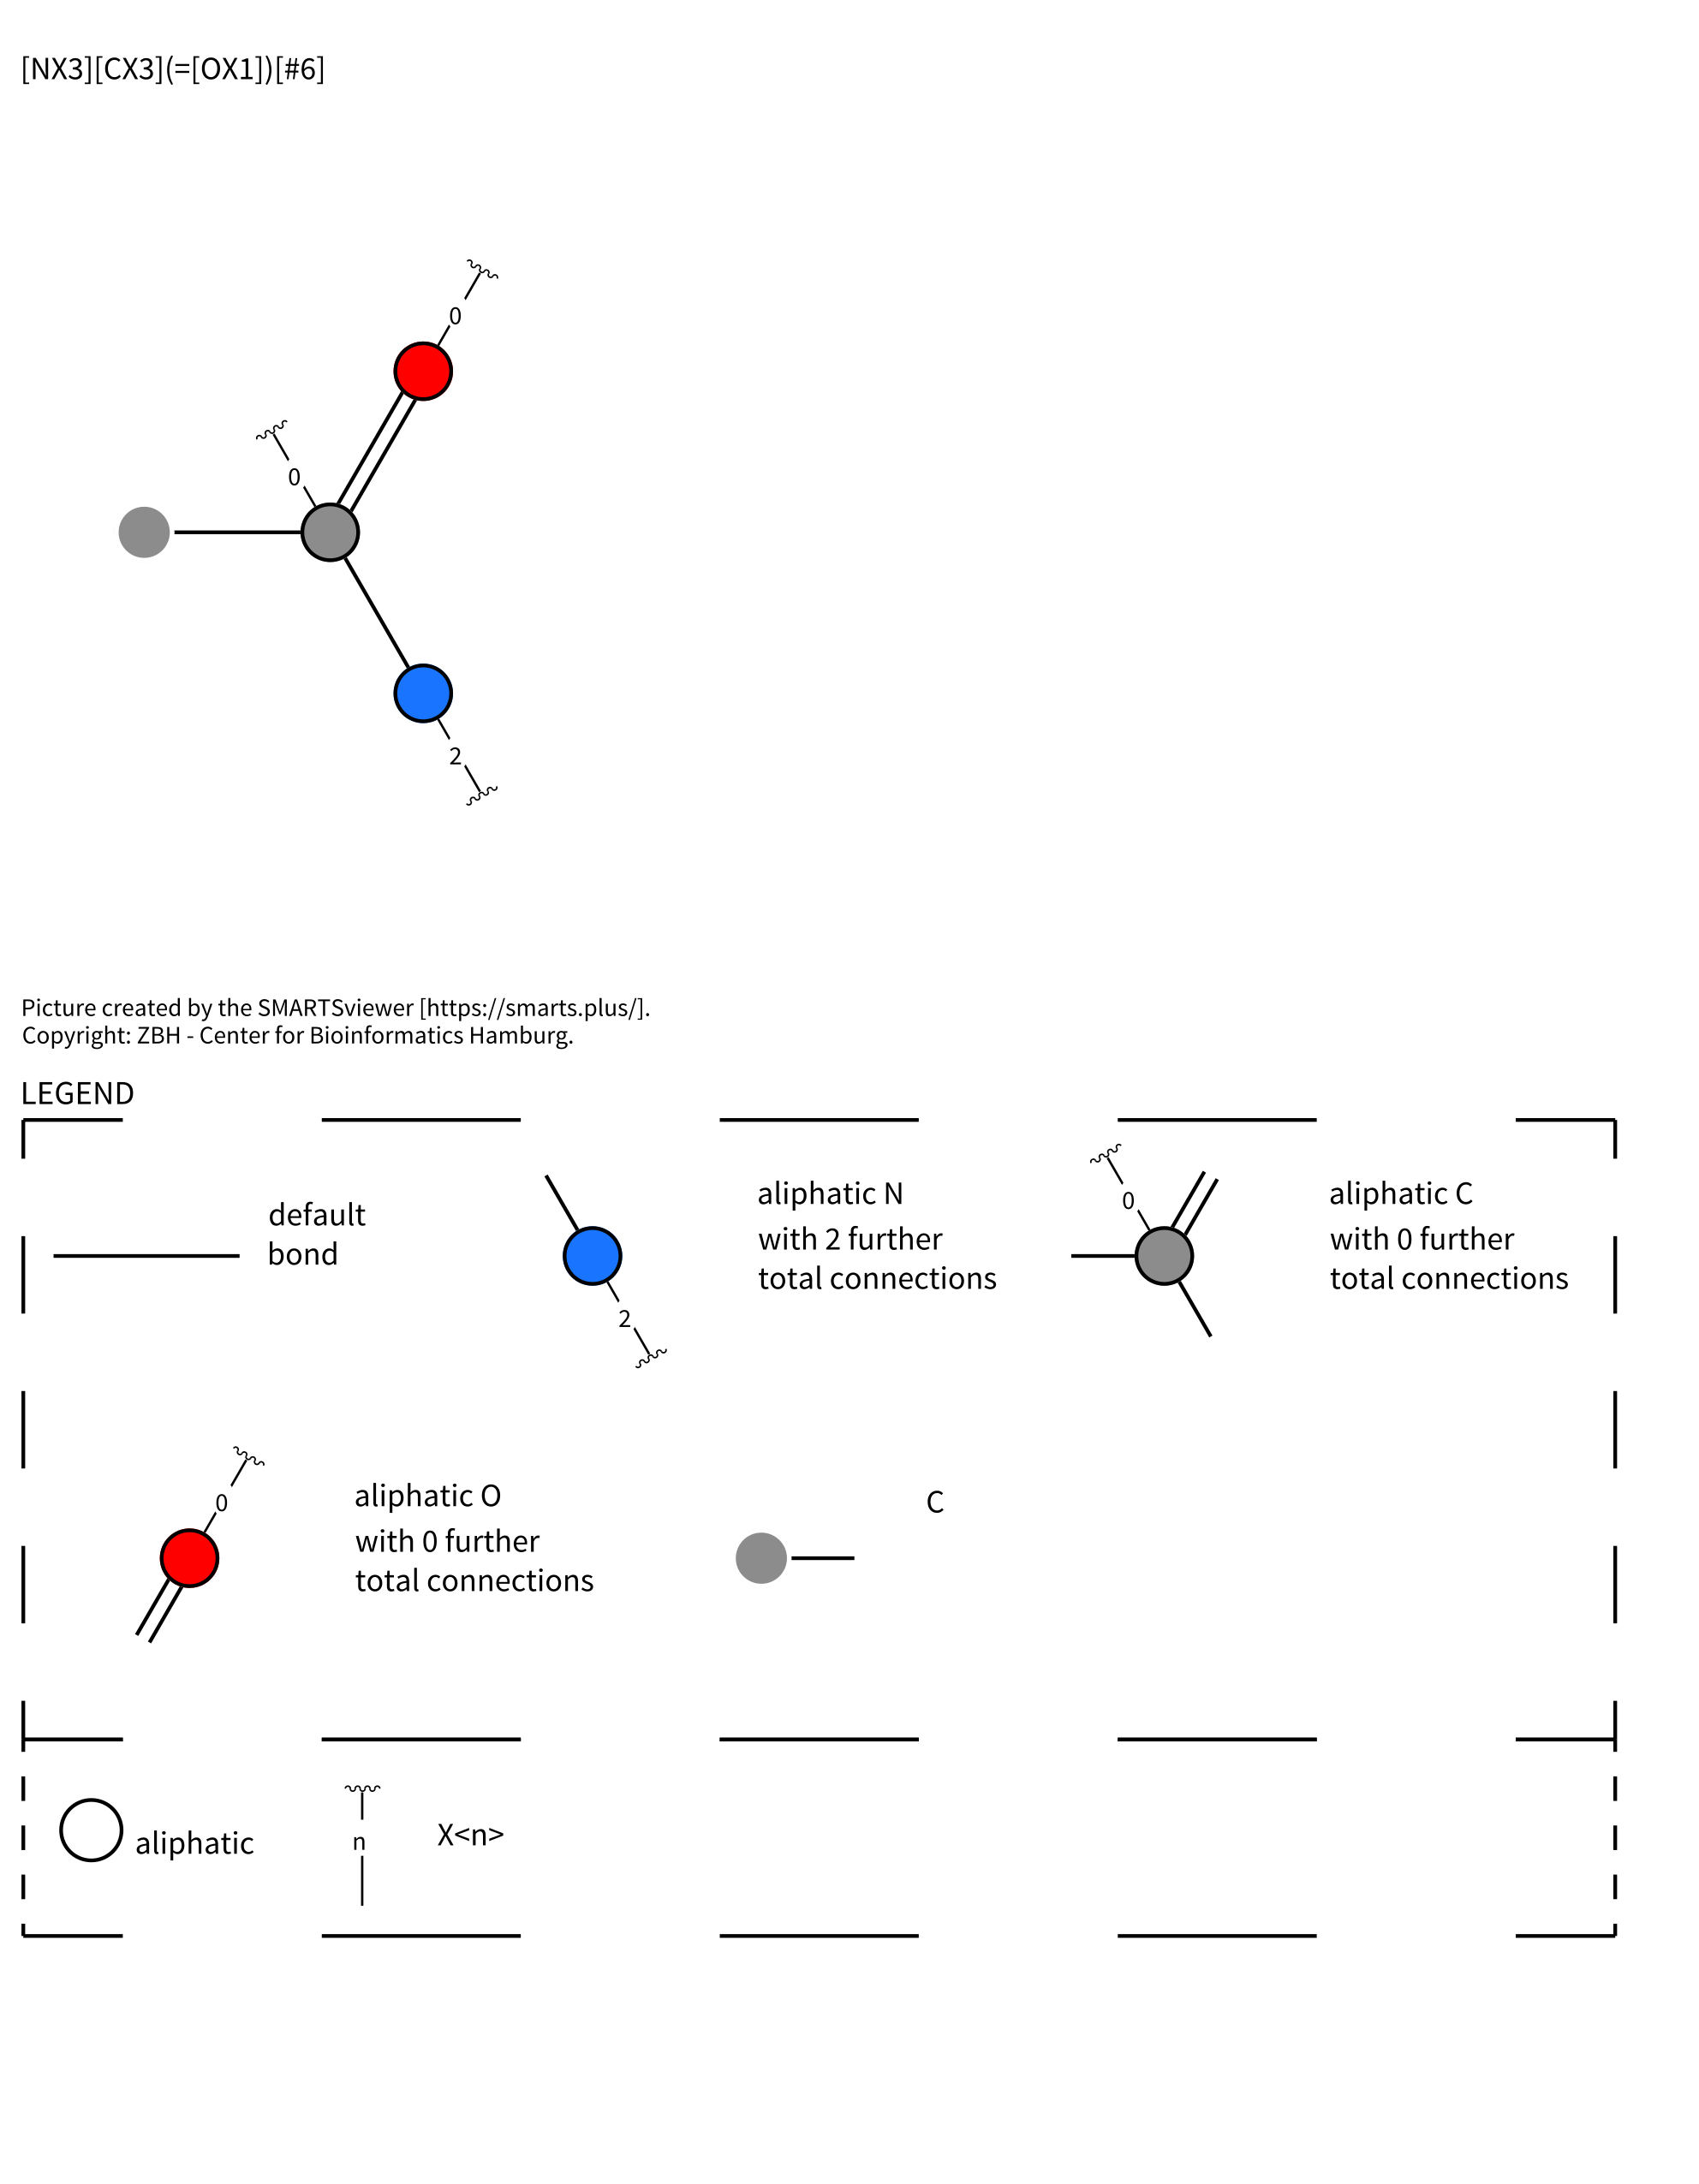

diglycolamide


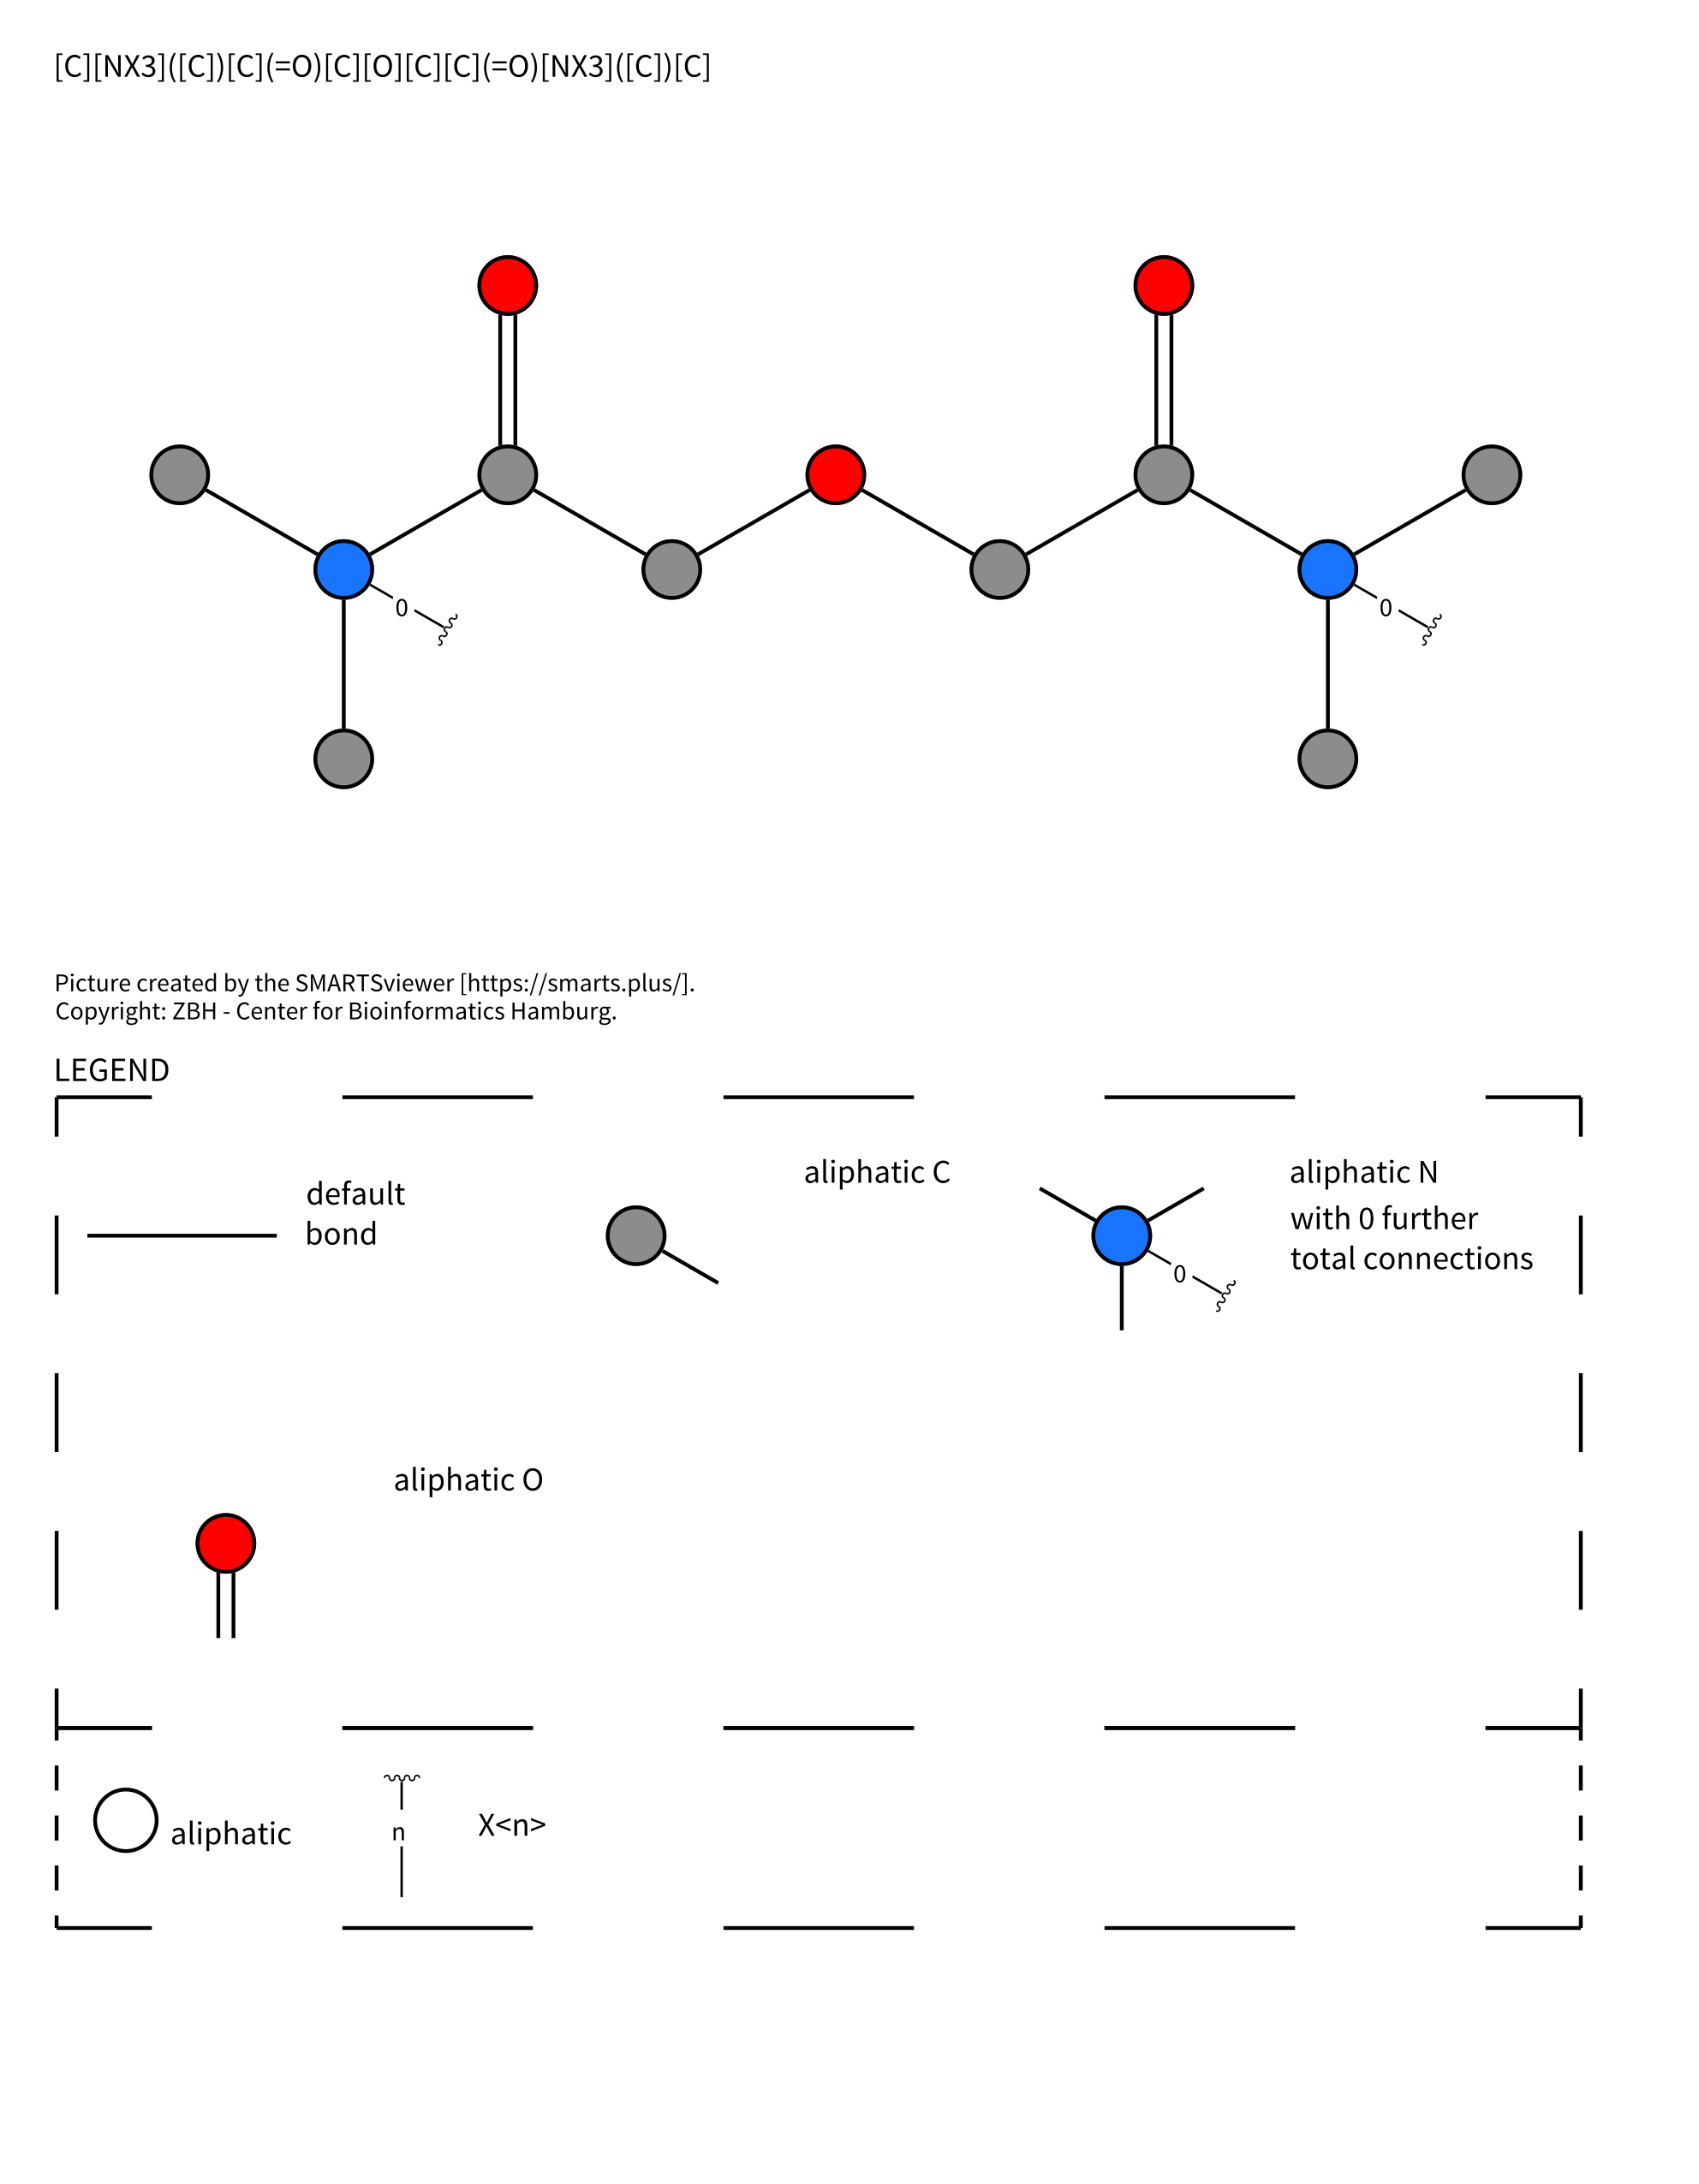

phosphineOxides


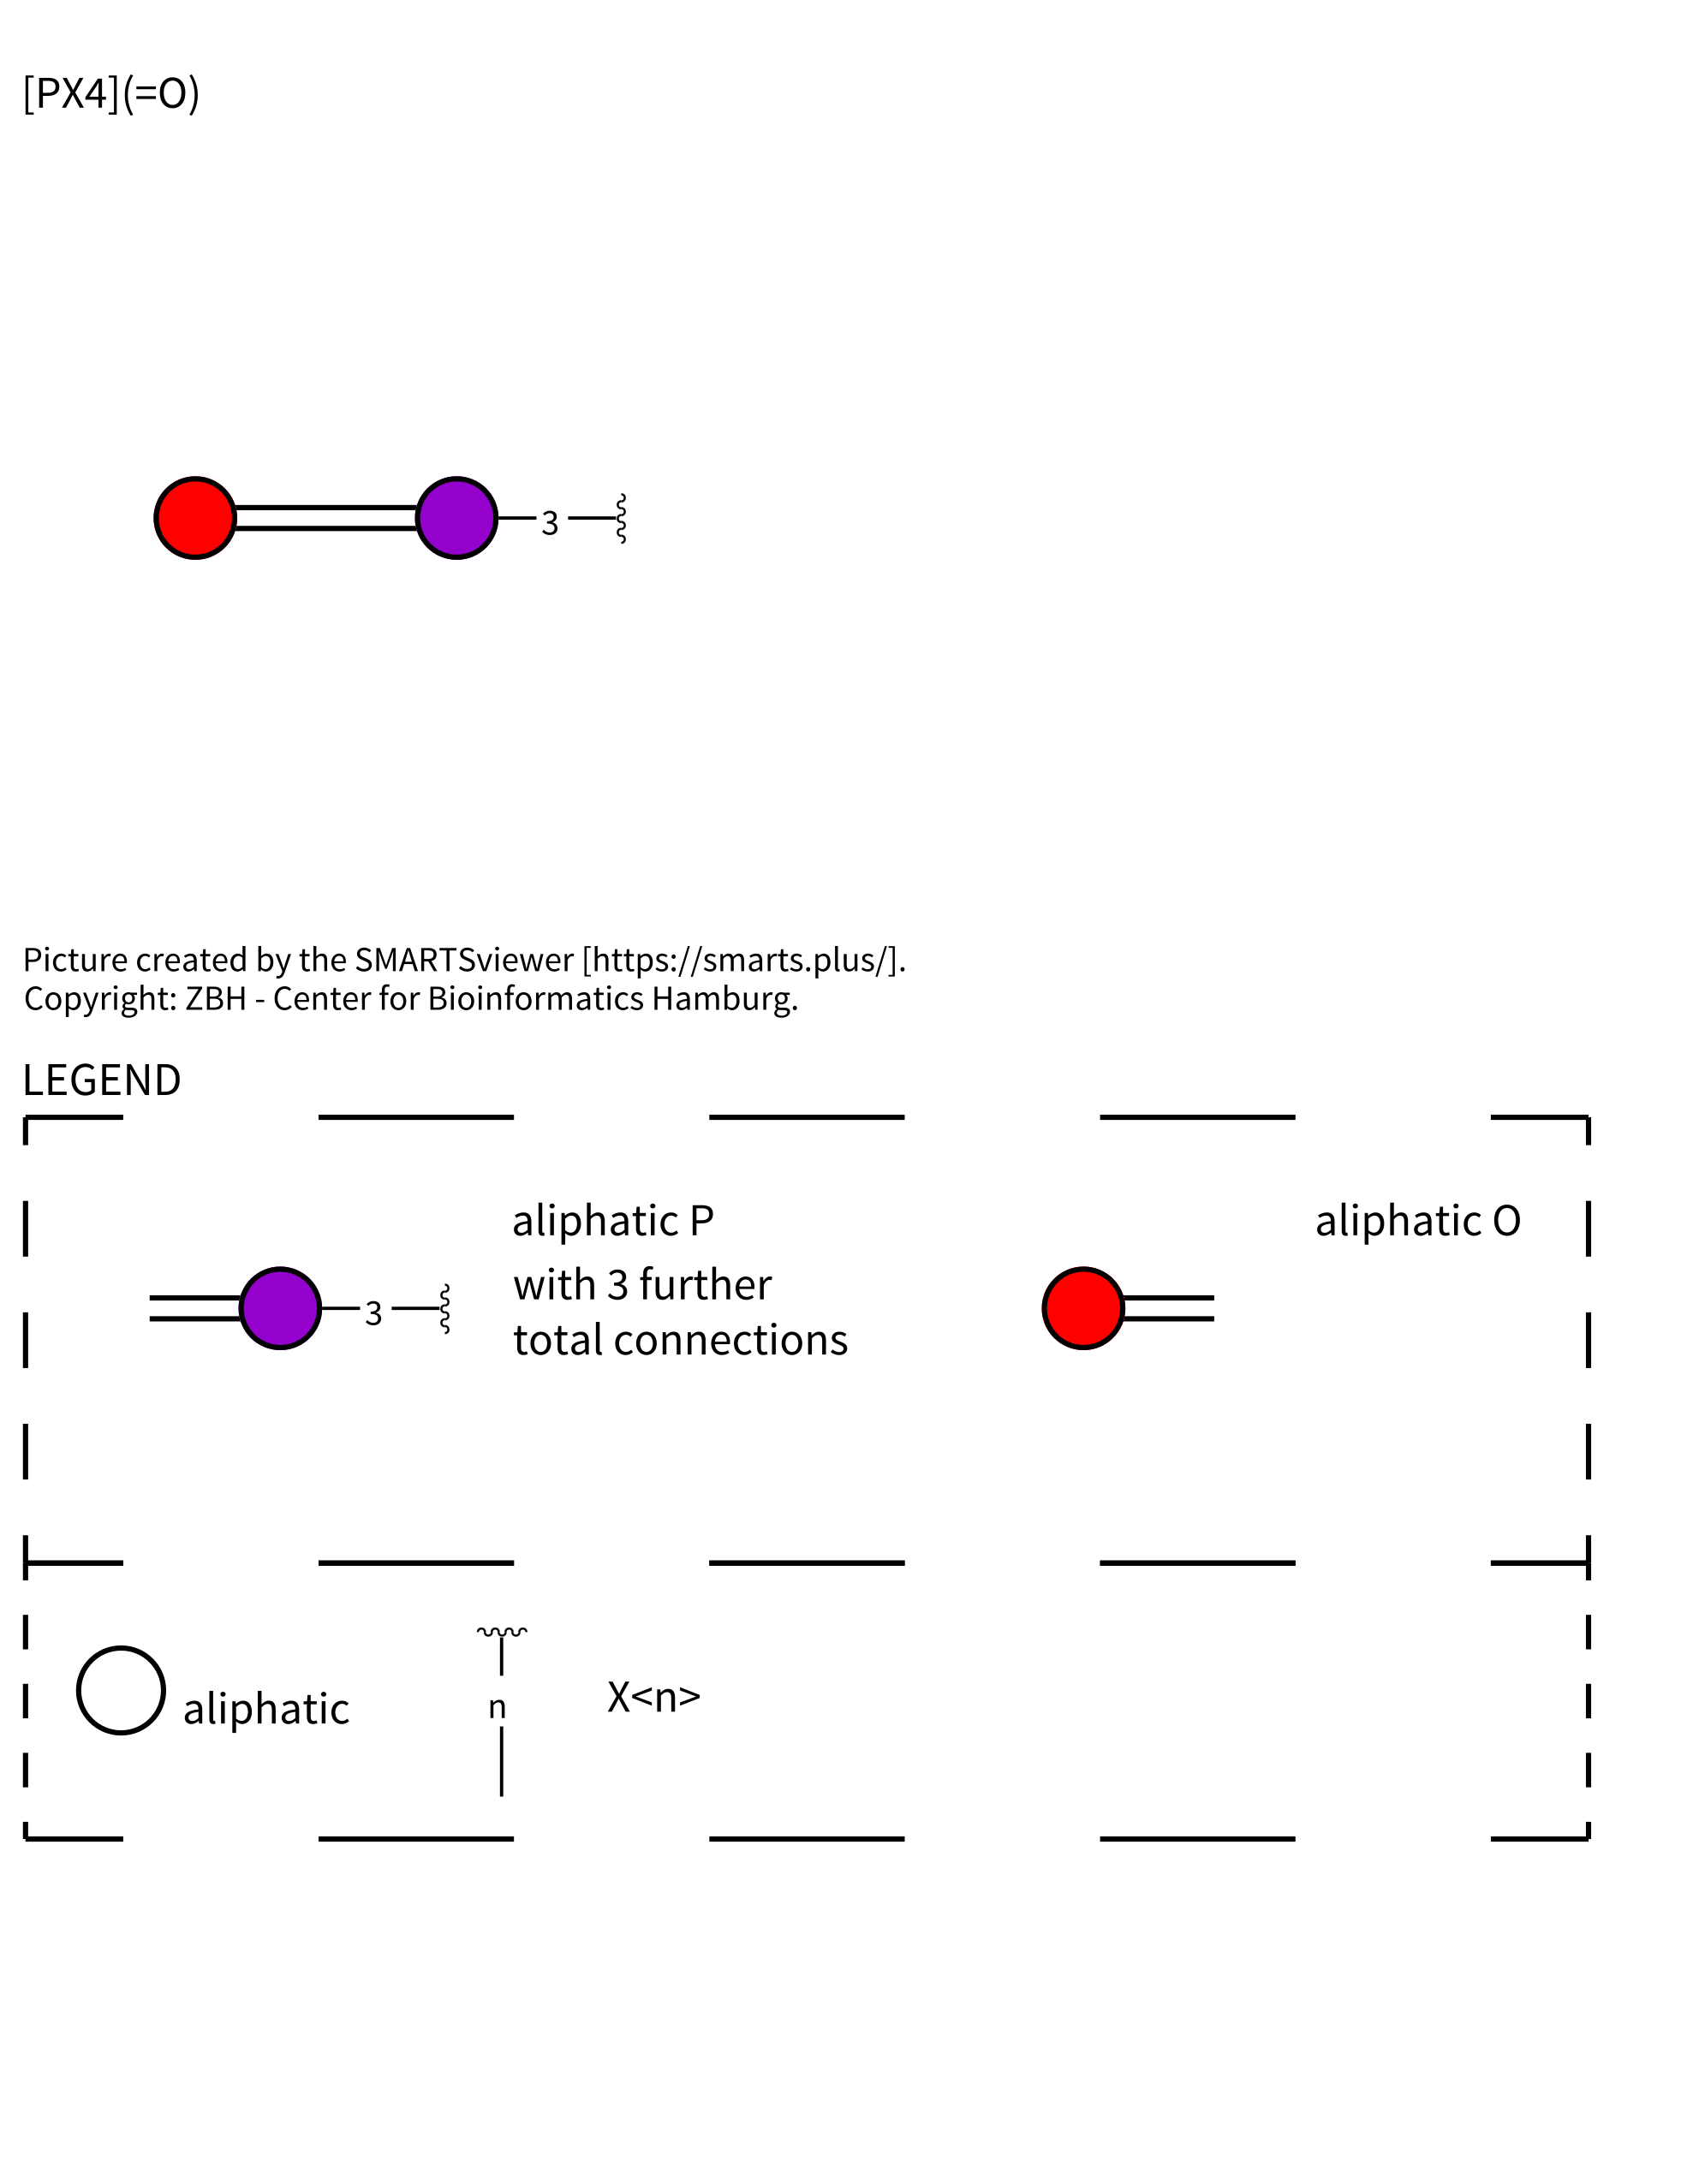

organophosphineOxides


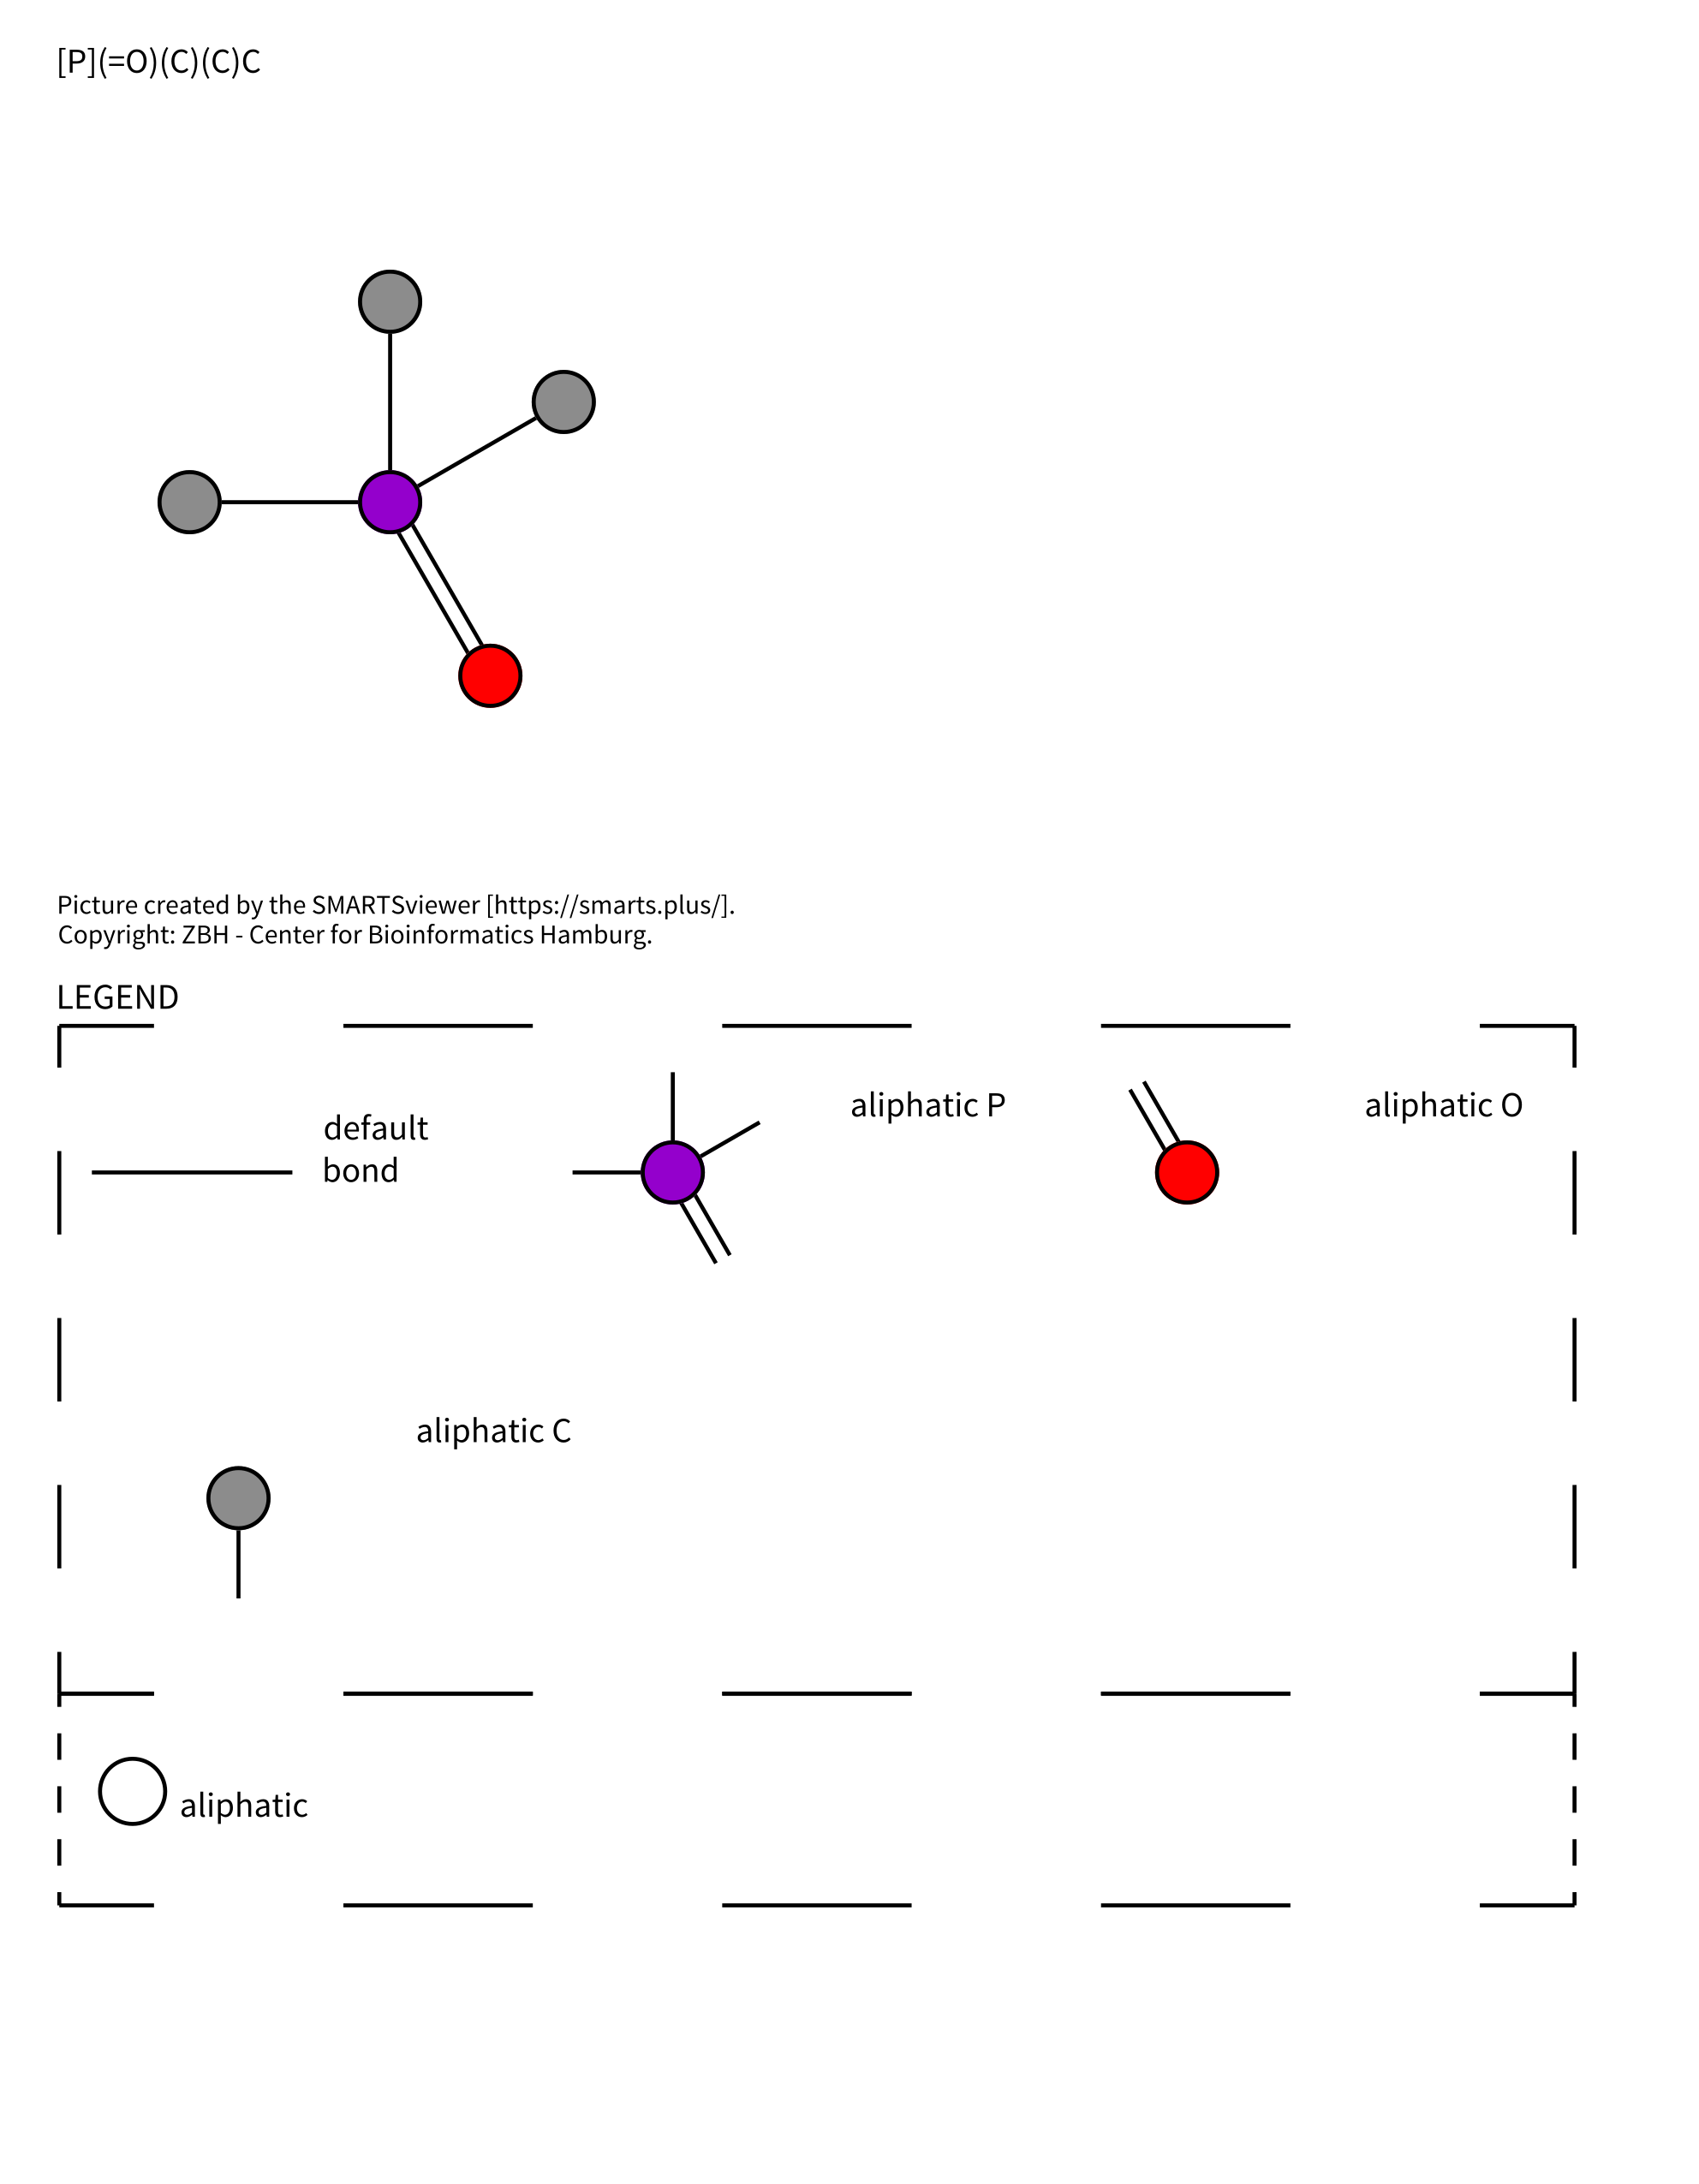

pyridine


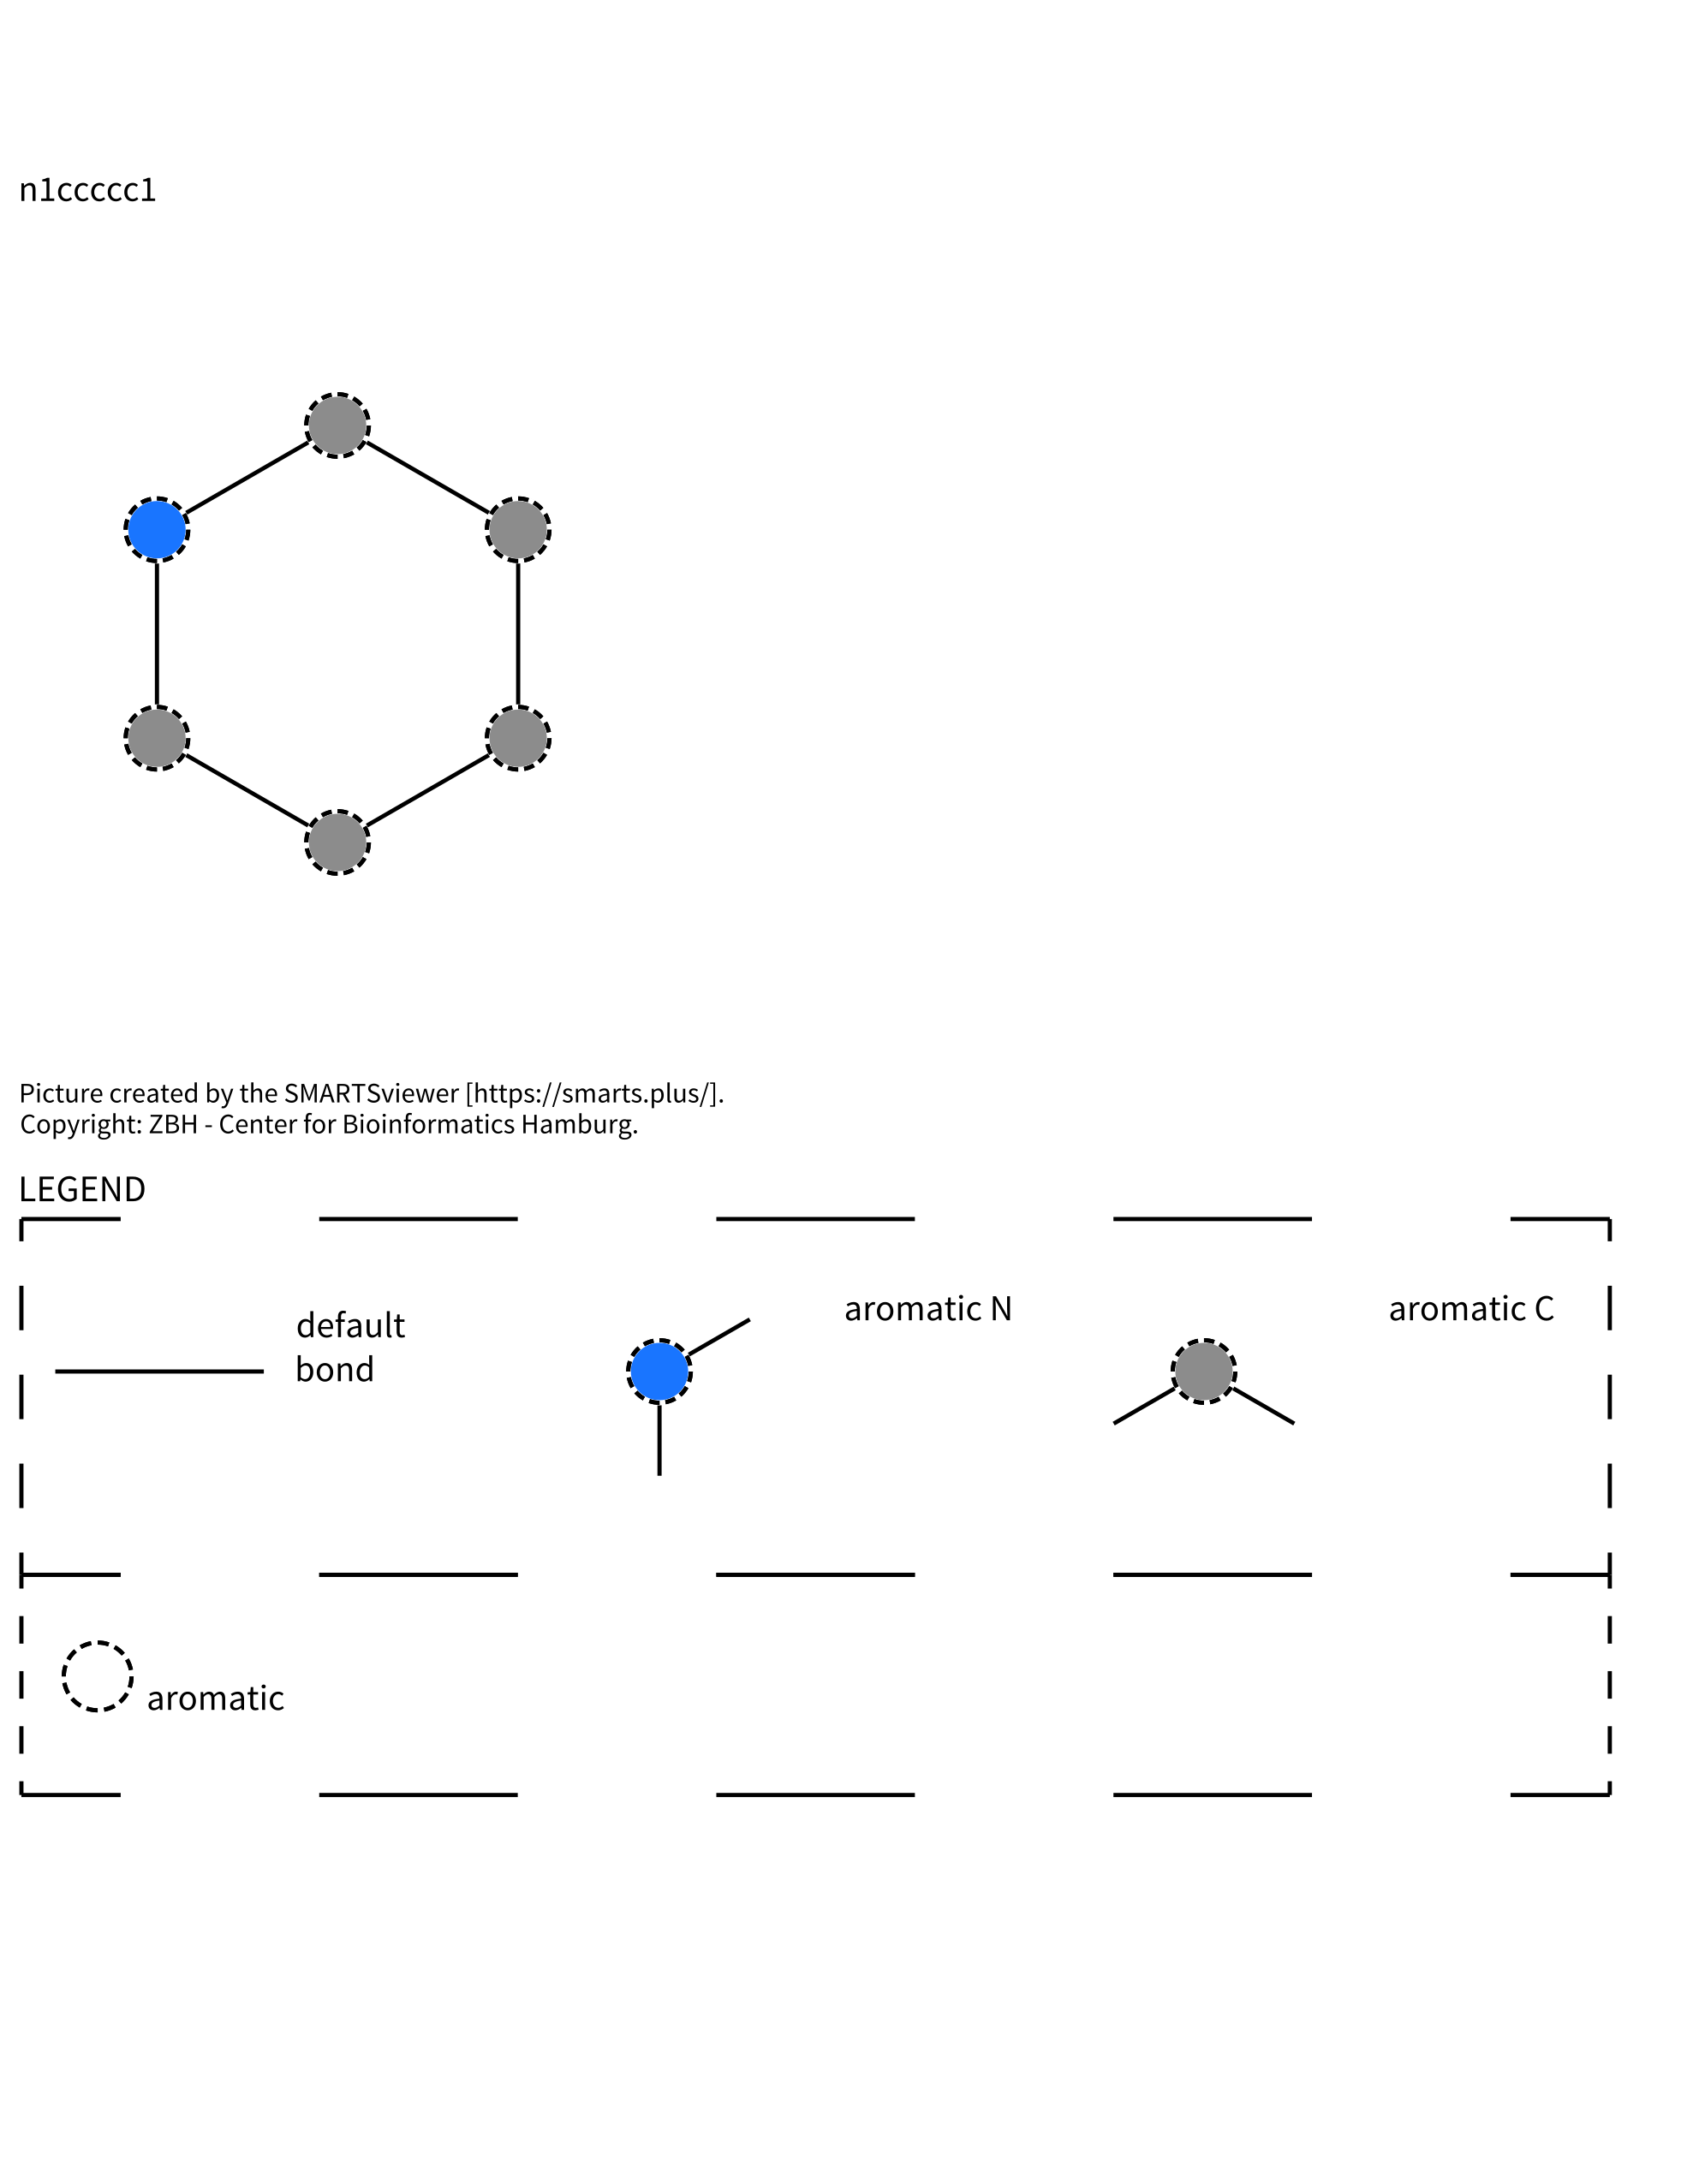

In [ ]:
for name, one_smart in name_smarts_series.items():
    query = get_query(one_smart)
    print(name)
    smarts_structure = get_smarts_structure(query)
    display(smarts_structure)